# Assignment 5

**Submission deadlines:**

  - Tuesday/Wednesday/Friday groups: 27-30.05.2025

**Points:** Aim to get 15 out of 17 points.

## Task 1 [3p]

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left; see the [data file](https://drive.google.com/file/d/1WoBT5OrTlNnjHg6jN90RnRb7krpEzFsP/view?usp=drive_link). The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss with negative sampling (NS) as in [Mikolov et al. 2013](https://arxiv.org/pdf/1310.4546) (see section 2.2). The loss function is as follows:
$$
 L = -\log \sigma(u_o^T v_c) - \sum_{i=1}^k \log \sigma(-u_i^T v_c);
$$
see [SKOS info](https://skos.ii.uni.wroc.pl/course/view.php?id=738#section-10) for more details.


Compute the gradient manually. You can use some gradient clipping, or regularizaton.


**Remark**: the data is specially prepared to make the learning process easier.
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


In [ ]:
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def load_data(filepath):
    pairs = []
    vocab = set()
    with open(filepath, 'r') as f:
        for line in f:
            obj, ctx = line.strip().split()
            pairs.append((obj, ctx))
            vocab.update([obj, ctx])
    return pairs, sorted(vocab)

def build_vocab(vocab):
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    return word2idx, idx2word

# unigram distribution (for negative sampling)
def build_unigram_table(pairs, word2idx, power=0.75):
    freq = defaultdict(int)
    for o, c in pairs:
        freq[c] += 1
    total = sum(freq.values())
    unigram_dist = np.array([freq[word] for word in word2idx])
    unigram_dist = unigram_dist ** power
    unigram_dist /= unigram_dist.sum()
    return unigram_dist


def sample_negatives(unigram_dist, num_samples):
    return np.random.choice(len(unigram_dist), size=num_samples, p=unigram_dist)


def train_word2vec(pairs, word2idx, dim=50, epochs=5, lr=0.025, k=5):
    vocab_size = len(word2idx)
    W_obj = np.random.randn(vocab_size, dim) * 0.01
    W_ctx = np.random.randn(vocab_size, dim) * 0.01
    unigram_dist = build_unigram_table(pairs, word2idx)

    for epoch in range(epochs):
        random.shuffle(pairs)
        for obj, ctx in tqdm(pairs, desc=f"Epoch {epoch+1}"):
            o_idx = word2idx[obj]
            c_idx = word2idx[ctx]
            neg_idxs = sample_negatives(unigram_dist, k)

            v_o = W_obj[o_idx]  # object vector
            v_c = W_ctx[c_idx]  # context vector

            # Positive sample loss and gradient
            score_pos = sigmoid(np.dot(v_o, v_c))
            grad_o = (score_pos - 1) * v_c
            grad_c = (score_pos - 1) * v_o

            W_obj[o_idx] -= lr * grad_o
            W_ctx[c_idx] -= lr * grad_c

            # Negative samples loss and gradients
            for neg_idx in neg_idxs:
                v_neg = W_ctx[neg_idx]
                score_neg = sigmoid(np.dot(v_o, v_neg))

                grad_o_neg = score_neg * v_neg
                grad_neg = score_neg * v_o

                W_obj[o_idx] -= lr * grad_o_neg
                W_ctx[neg_idx] -= lr * grad_neg

    return W_obj


def save_vectors(filename, vectors, idx2word):
    with open(filename, 'w') as f:
        for idx, vec in enumerate(vectors):
            word = idx2word[idx]
            vec_str = ' '.join(f"{x:.6f}" for x in vec)
            f.write(f"{word} {vec_str}\n")


def main(input_file, output_file, dim=50, epochs=5, lr=0.025, k=5):
    pairs, vocab = load_data(input_file)
    word2idx, idx2word = build_vocab(vocab)
    W_obj = train_word2vec(pairs, word2idx, dim=dim, epochs=epochs, lr=lr, k=k)
    save_vectors(output_file, W_obj, idx2word)


main("data1.txt", "vectors.txt", dim=50, epochs=5, lr=0.025, k=5)


Epoch 5: 100%|██████████| 483180/483180 [10:44<00:00, 749.74it/s]


#### Gradients for Positive Pair:

For the positive pair (object - context), the loss is:

$$
L_{\text{pos}} = - \log \sigma(u_o^T v_c)
$$

The gradients with respect to the object vector \$u\_o\$ and the context vector \$v\_c\$ are:

$$
\nabla u_o = (\sigma(u_o^T v_c) - 1) v_c
$$

$$
\nabla v_c = (\sigma(u_o^T v_c) - 1) u_o
$$

#### Gradients for Negative Samples:

For each negative sample \$n\_i\$, the loss is:

$$
L_{\text{neg}} = - \log \sigma(- u_{n_i}^T v_c)
$$

The gradients with respect to \$u\_o\$ and \$v\_c\$ for negative samples are:

$$
\nabla u_o = \sigma(u_o^T v_{n_i}) v_{n_i}
$$

$$
\nabla v_c = \sigma(u_o^T v_{n_i}) u_o
$$



In [ ]:
import numpy as np


def load_word_vectors(filename):
    word2vec_dict = {}
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array([float(val) for val in parts[1:]])
            word2vec_dict[word] = vector
    return word2vec_dict


def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


def compute_similarity_for_pairs(word2vec_dict, word_pairs):
    similarities = {}
    for word1, word2 in word_pairs:
        if word1 in word2vec_dict and word2 in word2vec_dict:
            vec1 = word2vec_dict[word1]
            vec2 = word2vec_dict[word2]
            similarity = cosine_similarity(vec1, vec2)
            similarities[(word1, word2)] = similarity
        else:
            similarities[(word1, word2)] = None  # missing words
    return similarities


if __name__ == "__main__":
    word2vec_dict = load_word_vectors('vectors.txt')

    word_pairs = [
        ('kobieta', 'mężczyzna'),
        ('kot', 'pies'),
        ('zebra', 'koń'),
        ('krzesło', 'stół'),
        ('król', 'królowa'),
        ('jabłko', 'banan'),
        ('smutny','wesoły'),
        ('mądry', 'głupi'),
        ('stary', 'młody'),
        ('dobry', 'zły'),
    ]


    similarities = compute_similarity_for_pairs(word2vec_dict, word_pairs)

    for (word1, word2), similarity in similarities.items():
        if similarity is not None:
            print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
        else:
            print(f"One or both words '{word1}' and '{word2}' not found in the vocabulary.")


Cosine similarity between 'kobieta' and 'mężczyzna': 0.9982
Cosine similarity between 'kot' and 'pies': 0.9972
Cosine similarity between 'zebra' and 'koń': 0.8938
Cosine similarity between 'krzesło' and 'stół': 0.9943
Cosine similarity between 'król' and 'królowa': 0.9947
Cosine similarity between 'jabłko' and 'banan': 0.9767
Cosine similarity between 'smutny' and 'wesoły': 0.1128
Cosine similarity between 'mądry' and 'głupi': -0.2094
Cosine similarity between 'stary' and 'młody': 0.0601
Cosine similarity between 'dobry' and 'zły': -0.1014


## Task 2 [2p*]

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file] containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

In [ ]:
import re
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from itertools import combinations
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')


with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if line.strip()]


titles = set([t for pair in raw_pairs for t in pair])

tokenized_titles = {title: word_tokenize(title.lower().replace('_', ' ')) for title in titles}


original_corpus = list(tokenized_titles.values())


unigram_counter = Counter()
bigram_counter = Counter()

for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(ngrams(tokens, 2))


UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2


rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}


rare_index = defaultdict(set)

for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in ngrams(tokens, 2):
        if bg in rare_bigrams:
            rare_index[" ".join(bg)].add(title)


related_pairs = set()
for titles_set in rare_index.values():
    for t1, t2 in combinations(sorted(titles_set), 2):
        related_pairs.add((t1, t2))


related_corpus = []
for t1, t2 in related_pairs:
    related_corpus.append(tokenized_titles[t1]+tokenized_titles[t2])
    related_corpus.append(tokenized_titles[t2]+tokenized_titles[t1])



mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(sentences=original_corpus, vector_size=100, window=5, min_count=1, workers=4)
model_original.save("word2vec_original.model")

model_mixed = Word2Vec(sentences=mixed_corpus, vector_size=100, window=5, min_count=1, workers=4)
model_mixed.save("word2vec_mixed.model")



def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("linear_search", "category:algorithms"),
    ("the_cat_in_the_hat", "house"),
    ("moab", "war")
]

print("\nTitle Similarity Comparison:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Title Similarity Comparison:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.6269 | Mixed: 0.5135
linear_search <-> category:algorithms
  Original: 0.5548 | Mixed: 0.4684
the_cat_in_the_hat <-> house
  Original: 0.6770 | Mixed: 0.5429
moab <-> war
  Original: 0.2697 | Mixed: 0.2687


In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")





Rare-Term Pair Similarity Comparison:

naginata <-> martial_art
  Original: 0.2206 | Mixed: 0.1948
list_of_j.league_players <-> kentaro_shigematsu
  Original: 0.3784 | Mixed: 0.2047
list_of_minor_planets:_67001–68000 <-> socorro,_nm
  Original: 0.3468 | Mixed: 0.2477
isabella_van_toorn <-> netherlands
  Original: 0.2669 | Mixed: 0.2769
list_of_programs_broadcast_by_cartoon_network <-> tokyopop
  Original: 0.1834 | Mixed: -0.0364
juan_carlos_molina_merlos <-> granada
  Original: 0.5844 | Mixed: 0.4813
arrondissement_of_issoudun <-> indre-et-loire
  Original: 0.4483 | Mixed: 0.3282
template:fortuna_düsseldorf_managers <-> josef_hickersberger
  Original: 0.2991 | Mixed: 0.0807
noel_ignatiev <-> category:american_historians
  Original: 0.3267 | Mixed: 0.2062
galileo_galilei <-> arcetri
  Original: 0.2531 | Mixed: 0.4821
rose_livingston <-> file:fola_la_follette,_rose_livingston_and_unidentified_striker.jpg
  Original: 0.6939 | Mixed: 0.6040
maure,_pyrénées-atlantiques <-> maure,_pyrénées-

In [ ]:
original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")


Comparison results for rare-word pairs:
Original better: 2307212
Mixed better:    610488
Equal:           4527
Skipped:         6


In [ ]:
import re
import random
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk

random.seed(42)
nltk.download('punkt')

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = set(t for pair in raw_pairs for t in pair)
tokenized_titles = {title: word_tokenize(title.lower().replace('_', ' ')) for title in titles}
original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in original_corpus:
    unigram_counter.update(tokens)
    bigram_counter.update(ngrams(tokens, 2))

UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}

rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in ngrams(tokens, 2):
        if bg in rare_bigrams:
            rare_index[" ".join(bg)].add(title)

related_pairs = set()
for titles_set in rare_index.values():
    for t1, t2 in combinations(sorted(titles_set), 2):
        tokens1 = tokenized_titles.get(t1, [])
        tokens2 = tokenized_titles.get(t2, [])
        if tokens1 and tokens2:
            inter = set(tokens1) & set(tokens2)
            union = set(tokens1) | set(tokens2)
            jaccard_sim = len(inter) / len(union) if union else 0
            if jaccard_sim > 0.2:
                related_pairs.add((t1, t2))

related_corpus = []
for t1, t2 in related_pairs:
    tokens1 = tokenized_titles[t1]
    tokens2 = tokenized_titles[t2]
    related_corpus.append(["related"] + tokens1 + ["and"] + tokens2)
    related_corpus.append(["related"] + tokens2 + ["and"] + tokens1)

mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(sentences=original_corpus, vector_size=100, window=5, min_count=1, workers=4, seed=42)
model_original.save("word2vec_original.model")

model_mixed = Word2Vec(sentences=mixed_corpus, vector_size=100, window=5, min_count=1, workers=4, seed=42)
model_mixed.save("word2vec_mixed.model")

def title_similarity(model, t1, t2):
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if tokens1 and tokens2:
        try:
            return model.wv.n_similarity(tokens1, tokens2)
        except KeyError:
            return None
    return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("linear_search", "category:algorithms"),
    ("the_cat_in_the_hat", "house"),
    ("moab", "war")
]

print("\nTitle Similarity Comparison:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")
    else:
        print(f"{t1} <-> {t2}  --> Skipped")

def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

rare_word_pairs = [pair for pair in raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

better_original = 0
better_mixed = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is None or sim_mixed is None:
        skipped += 1
        continue
    if abs(sim_orig - sim_mixed) < 1e-6:
        equal += 1
    elif sim_orig > sim_mixed:
        better_original += 1
    else:
        better_mixed += 1

print("\nEvaluation on Rare-Term Pairs:")
print(f"Original better: {better_original}")
print(f"Mixed better:    {better_mixed}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Title Similarity Comparison:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.6365 | Mixed: 0.5114
linear_search <-> category:algorithms
  Original: 0.5771 | Mixed: 0.4917
the_cat_in_the_hat <-> house
  Original: 0.6799 | Mixed: 0.5917
moab <-> war
  Original: 0.4373 | Mixed: 0.3222

Evaluation on Rare-Term Pairs:
Original better: 2371352
Mixed better:    542499
Equal:           8376
Skipped:         6


In [ ]:
import re
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")


with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = set([t for pair in raw_pairs for t in pair])
tokenized_titles = {title: word_tokenize(title.lower().replace("_", " ")) for title in titles}
original_corpus = list(tokenized_titles.values())


unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(ngrams(tokens, 2))


UNIGRAM_THRESHOLD = 5
BIGRAM_THRESHOLD = 3

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}


rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in ngrams(tokens, 2):
        if bg in rare_bigrams:
            rare_index[" ".join(bg)].add(title)

def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
for titles_set in rare_index.values():
    for t1, t2 in combinations(sorted(titles_set), 2):
        if jaccard(t1, t2) >= 0.2:
            related_pairs.add((t1, t2))

MAX_AUGMENT = len(original_corpus)
related_pairs = list(related_pairs)[:MAX_AUGMENT]

related_corpus = [tokenized_titles[t1] + tokenized_titles[t2] for t1, t2 in related_pairs]

mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(sentences=original_corpus, vector_size=100, window=5, min_count=1, workers=4)
model_original.save("word2vec_original.model")

model_mixed = Word2Vec(sentences=mixed_corpus, vector_size=100, window=5, min_count=1, workers=4)
model_mixed.save("word2vec_mixed.model")

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("linear_search", "category:algorithms"),
    ("the_cat_in_the_hat", "house"),
    ("moab", "war")
]

print("\nTitle Similarity Comparison:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")
    else:
        print("  Skipped (missing tokens)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Title Similarity Comparison:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.6123 | Mixed: 0.5662
linear_search <-> category:algorithms
  Original: 0.5717 | Mixed: 0.4815
the_cat_in_the_hat <-> house
  Original: 0.6998 | Mixed: 0.5572
moab <-> war
  Original: 0.3981 | Mixed: 0.3436


In [ ]:
original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")


Comparison results for rare-word pairs:
Original better: 2367703
Mixed better:    549977
Equal:           4547
Skipped:         6


In [ ]:
import re
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = set([t for pair in raw_pairs for t in pair])
tokenized_titles = {title: word_tokenize(title.lower().replace("_", " ")) for title in titles}
original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(ngrams(tokens, 2))


UNIGRAM_THRESHOLD = 5
BIGRAM_THRESHOLD = 3

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}


rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in ngrams(tokens, 2):
        if bg in rare_bigrams:
            rare_index[" ".join(bg)].add(title)


def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
for titles_set in rare_index.values():
    for t1, t2 in combinations(sorted(titles_set), 2):
        if jaccard(t1, t2) >= 0.2:
            related_pairs.add((t1, t2))


MAX_AUGMENT = len(original_corpus)
related_pairs = list(related_pairs)[:MAX_AUGMENT]
related_corpus = [tokenized_titles[t1] + tokenized_titles[t2] for t1, t2 in related_pairs]


mixed_corpus = original_corpus + related_corpus


model_original = Word2Vec(sentences=original_corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1)
model_original.save("word2vec_original.model")

model_mixed = Word2Vec(sentences=mixed_corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1)
model_mixed.save("word2vec_mixed.model")

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None


test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("linear_search", "category:algorithms"),
    ("the_cat_in_the_hat", "house"),
    ("moab", "war")
]

print("\nTitle Similarity Comparison:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")
        # Optional: interpolated score
        # ensemble = (0.4 * sim_orig + 0.6 * sim_mixed)
        # print(f"  Ensemble: {ensemble:.4f}")
    else:
        print(f"{t1} <-> {t2} - Skipped (missing token)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Title Similarity Comparison:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.8402 | Mixed: 0.7557
linear_search <-> category:algorithms
  Original: 0.7242 | Mixed: 0.6004
the_cat_in_the_hat <-> house
  Original: 0.6782 | Mixed: 0.5908
moab <-> war
  Original: 0.6367 | Mixed: 0.4919


In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")



Rare-Term Pair Similarity Comparison:

list_of_programs_broadcast_by_cartoon_network <-> tokyopop
  Original: -0.0155 | Mixed: -0.0017
juan_carlos_molina_merlos <-> granada
  Original: 0.6734 | Mixed: 0.4842
arrondissement_of_issoudun <-> indre-et-loire
  Original: 0.7467 | Mixed: 0.6678
booby_trap <-> tripwire
  Original: 0.8315 | Mixed: 0.6802
template:fortuna_düsseldorf_managers <-> josef_hickersberger
  Original: 0.4476 | Mixed: 0.2500
noel_ignatiev <-> category:american_historians
  Original: 0.6437 | Mixed: 0.4476
north_lanarkshire <-> airdrie_and_shotts_(uk_parliament_constituency)
  Original: 0.6994 | Mixed: 0.6216
galileo_galilei <-> arcetri
  Original: 0.6467 | Mixed: 0.6224
rose_livingston <-> file:fola_la_follette,_rose_livingston_and_unidentified_striker.jpg
  Original: 0.8899 | Mixed: 0.8441
maure,_pyrénées-atlantiques <-> maure,_pyrénées-atlantiques
  Original: 1.0000 | Mixed: 1.0000
wikipedia:requests_for_bureaucratship/bluegoblin7 <-> user_talk:razorflame
  Original: 

In [ ]:
import re
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = set([t for pair in raw_pairs for t in pair])
tokenized_titles = {title: word_tokenize(title.lower().replace("_", " ")) for title in titles}
original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(ngrams(tokens, 2))

UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2
JACCARD_THRESHOLD = 0.3
MAX_PAIRS_PER_TERM = 5

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}

rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in ngrams(tokens, 2):
        if bg in rare_bigrams:
            rare_index[" ".join(bg)].add(title)

def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
for term, titles_set in rare_index.items():
    titles_list = sorted(titles_set)
    pair_count = 0
    for t1, t2 in combinations(titles_list, 2):
        if jaccard(t1, t2) >= JACCARD_THRESHOLD:
            related_pairs.add((t1, t2))
            pair_count += 1
            if pair_count >= MAX_PAIRS_PER_TERM:
                break

related_corpus = [tokenized_titles[t1] + tokenized_titles[t2] for t1, t2 in related_pairs]
mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(
    sentences=original_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

model_mixed = Word2Vec(
    sentences=mixed_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("linear_search", "category:algorithms"),
    ("the_cat_in_the_hat", "house"),
    ("moab", "war"),
    ("machine_learning", "artificial_intelligence"),
    ("quantum_mechanics", "particle_physics")
]

print("\nTitle Similarity Comparison:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f} | Diff: {sim_mixed-sim_orig:+.4f}")
    else:
        print("  Skipped (missing tokens)")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Title Similarity Comparison:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.4812 | Mixed: 0.4887 | Diff: +0.0075
linear_search <-> category:algorithms
  Original: 0.5252 | Mixed: 0.5045 | Diff: -0.0207
the_cat_in_the_hat <-> house
  Original: 0.5508 | Mixed: 0.5222 | Diff: -0.0287
moab <-> war
  Original: 0.3508 | Mixed: 0.3135 | Diff: -0.0373
machine_learning <-> artificial_intelligence
  Original: 0.7730 | Mixed: 0.7109 | Diff: -0.0621
quantum_mechanics <-> particle_physics
  Original: 0.9271 | Mixed: 0.9157 | Diff: -0.0114


In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")



Rare-Term Pair Similarity Comparison:

naginata <-> martial_art
  Original: 0.2396 | Mixed: 0.2724
list_of_j.league_players <-> kentaro_shigematsu
  Original: 0.1786 | Mixed: 0.1093
list_of_minor_planets:_67001–68000 <-> socorro,_nm
  Original: 0.2322 | Mixed: 0.2145
isabella_van_toorn <-> netherlands
  Original: 0.1626 | Mixed: 0.1471
list_of_programs_broadcast_by_cartoon_network <-> tokyopop
  Original: -0.0127 | Mixed: 0.0948
juan_carlos_molina_merlos <-> granada
  Original: 0.4422 | Mixed: 0.4047
arrondissement_of_issoudun <-> indre-et-loire
  Original: 0.3326 | Mixed: 0.3080
template:fortuna_düsseldorf_managers <-> josef_hickersberger
  Original: 0.1084 | Mixed: 0.0279
noel_ignatiev <-> category:american_historians
  Original: 0.1750 | Mixed: 0.1366
galileo_galilei <-> arcetri
  Original: 0.5916 | Mixed: 0.2415
rose_livingston <-> file:fola_la_follette,_rose_livingston_and_unidentified_striker.jpg
  Original: 0.6439 | Mixed: 0.6180
maure,_pyrénées-atlantiques <-> maure,_pyrénées-

In [ ]:
import re
import random
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from tqdm import tqdm
import spacy
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize

nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

SUBSET_SIZE = 500_000

def spacy_tokenizer(text):
    return [token.text.lower() for token in nlp(text) if not token.is_punct]

def regex_tokenizer(text):
    return regexp_tokenize(text.lower(), r'\b\w[\w\-]+\w\b')

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = list(set([t for pair in raw_pairs for t in pair]))
random.seed(42)
random.shuffle(titles)
titles = titles[:SUBSET_SIZE]

tokenizers = {
    'nltk': lambda x: word_tokenize(x.lower().replace("_", " ")),
    'spacy': lambda x: spacy_tokenizer(x.replace("_", " ")),
    'regex': lambda x: regex_tokenizer(x.replace("_", " "))
}

selected_tokenizer = 'spacy'
tokenized_titles = {}
for title in tqdm(titles, desc="Tokenizing titles"):
    tokenized_titles[title] = tokenizers[selected_tokenizer](title)

original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(zip(tokens, tokens[1:]))

UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2
JACCARD_THRESHOLD = 0.4
MAX_RELATED = 100_000

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}

rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in zip(tokens, tokens[1:]):
        if bg in rare_bigrams:
            rare_index[f"{bg[0]}_{bg[1]}"].add(title)

def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
pair_count = 0
for term, titles_set in tqdm(rare_index.items(), desc="Finding related pairs"):
    for t1, t2 in combinations(sorted(titles_set), 2):
        if pair_count >= MAX_RELATED:
            break
        if jaccard(t1, t2) >= JACCARD_THRESHOLD:
            related_pairs.add((t1, t2))
            pair_count += 1

related_corpus = []
for t1, t2 in tqdm(related_pairs, desc="Building related corpus"):
    related_corpus.append(tokenized_titles[t1] + tokenized_titles[t2])

mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(
    sentences=original_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

model_mixed = Word2Vec(
    sentences=mixed_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("machine_learning", "artificial_intelligence"),
    ("new_york", "los_angeles"),
    ("star_wars", "star_trek"),
    ("python", "java"),
    ("football", "soccer")
]

print(f"\nResults using {selected_tokenizer} tokenizer:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f} | Improvement: {sim_mixed-sim_orig:+.4f}")
    else:
        print("  Skipped (missing tokens)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Building related corpus: 100%|██████████| 37255/37255 [00:00<00:00, 258171.89it/s]



Results using spacy tokenizer:

marie_antoinette <-> louis_xvi_of_france
  Skipped (missing tokens)
machine_learning <-> artificial_intelligence
  Original: 0.2500 | Mixed: 0.3144 | Improvement: +0.0645
new_york <-> los_angeles
  Skipped (missing tokens)
star_wars <-> star_trek
  Skipped (missing tokens)
python <-> java
  Skipped (missing tokens)
football <-> soccer
  Skipped (missing tokens)


In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")



Rare-Term Pair Similarity Comparison:

Comparison results for rare-word pairs:
Original better: 3494
Mixed better:    2510
Equal:           492
Skipped:         271476


In [ ]:
test_pairs = [
    ("machine_learning", "artificial_intelligence"),
    ("guitar", "music"),
    ("piety", "pride")
]

print(f"\nResults using {selected_tokenizer} tokenizer:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f} | Improvement: {sim_mixed-sim_orig:+.4f}")
    else:
        print("  Skipped (missing tokens)")


Results using spacy tokenizer:

machine_learning <-> artificial_intelligence
  Original: 0.2500 | Mixed: 0.3144 | Improvement: +0.0645
guitar <-> music
  Original: 0.1931 | Mixed: 0.2668 | Improvement: +0.0737
piety <-> pride
  Original: -0.0712 | Mixed: -0.0004 | Improvement: +0.0707


In [ ]:
import re
import random
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from tqdm import tqdm
import spacy
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize

nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

SUBSET_SIZE = 500_000

def spacy_tokenizer(text):
    return [token.text.lower() for token in nlp(text) if not token.is_punct]

def regex_tokenizer(text):
    return regexp_tokenize(text.lower(), r'\b\w[\w\-]+\w\b')

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = list(set([t for pair in raw_pairs for t in pair]))
random.seed(42)
random.shuffle(titles)
titles = titles[:SUBSET_SIZE]

tokenizers = {
    'nltk': lambda x: word_tokenize(x.lower().replace("_", " ")),
    'spacy': lambda x: spacy_tokenizer(x.replace("_", " ")),
    'regex': lambda x: regex_tokenizer(x.replace("_", " "))
}

selected_tokenizer = 'regex'
tokenized_titles = {}
for title in tqdm(titles, desc="Tokenizing titles"):
    tokenized_titles[title] = tokenizers[selected_tokenizer](title)

original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(zip(tokens, tokens[1:]))

UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2
JACCARD_THRESHOLD = 0.4
MAX_RELATED = 100_000

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}

rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in zip(tokens, tokens[1:]):
        if bg in rare_bigrams:
            rare_index[f"{bg[0]}_{bg[1]}"].add(title)

def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
pair_count = 0
for term, titles_set in tqdm(rare_index.items(), desc="Finding related pairs"):
    for t1, t2 in combinations(sorted(titles_set), 2):
        if pair_count >= MAX_RELATED:
            break
        if jaccard(t1, t2) >= JACCARD_THRESHOLD:
            related_pairs.add((t1, t2))
            pair_count += 1

related_corpus = []
for t1, t2 in tqdm(related_pairs, desc="Building related corpus"):
    related_corpus.append(tokenized_titles[t1] + tokenized_titles[t2])

mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(
    sentences=original_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

model_mixed = Word2Vec(
    sentences=mixed_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("machine_learning", "artificial_intelligence"),
    ("new_york", "los_angeles"),
    ("star_wars", "star_trek"),
    ("python", "java"),
    ("football", "soccer")
]

print(f"\nResults using {selected_tokenizer} tokenizer:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f} | Improvement: {sim_mixed-sim_orig:+.4f}")
    else:
        print("  Skipped (missing tokens)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Building related corpus: 100%|██████████| 39268/39268 [00:00<00:00, 333127.56it/s]



Results using regex tokenizer:

marie_antoinette <-> louis_xvi_of_france
  Original: 0.4232 | Mixed: 0.3689 | Improvement: -0.0543
machine_learning <-> artificial_intelligence
  Skipped (missing tokens)
new_york <-> los_angeles
  Skipped (missing tokens)
star_wars <-> star_trek
  Skipped (missing tokens)
python <-> java
  Skipped (missing tokens)
football <-> soccer
  Skipped (missing tokens)


In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")



Rare-Term Pair Similarity Comparison:

swatantra_party <-> c._rajagopalachari
  Original: 0.1267 | Mixed: 0.2134
ifor <-> 1st_the_queen's_dragoon_guards
  Original: -0.0410 | Mixed: 0.1987
speaker_of_the_lok_sabha <-> neelam_sanjiva_reddy
  Original: 0.3319 | Mixed: 0.3103
wikipedia:editor_review/mentifisto <-> special:recentchangeslinked
  Original: 0.2016 | Mixed: 0.2632
template:province_of_cuneo <-> monticello_d'alba
  Original: -0.0565 | Mixed: -0.0464
cross-sex_friendship <-> implication
  Original: 0.0473 | Mixed: 0.0475
évry-courcouronnes <-> communes_of_france
  Original: 0.0993 | Mixed: -0.0527
Comparison results for rare-word pairs:
Original better: 186738
Mixed better:    173139
Equal:           3283
Skipped:         942766


In [ ]:
import re
import random
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from itertools import combinations
from tqdm import tqdm
import spacy
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize

nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')



def spacy_tokenizer(text):
    return [token.text.lower() for token in nlp(text) if not token.is_punct]

def regex_tokenizer(text):
    return regexp_tokenize(text.lower(), r'\b\w[\w\-]+\w\b')

with open("task2_simple.wiki.links.txt", "r", encoding="utf-8") as f:
    raw_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

titles = list(set([t for pair in raw_pairs for t in pair]))
random.seed(42)
random.shuffle(titles)


tokenizers = {
    'nltk': lambda x: word_tokenize(x.lower().replace("_", " ")),
    'spacy': lambda x: spacy_tokenizer(x.replace("_", " ")),
    'regex': lambda x: regex_tokenizer(x.replace("_", " "))
}

selected_tokenizer = 'regex'
tokenized_titles = {}
for title in tqdm(titles, desc="Tokenizing titles"):
    tokenized_titles[title] = tokenizers[selected_tokenizer](title)

original_corpus = list(tokenized_titles.values())

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in tokenized_titles.values():
    unigram_counter.update(tokens)
    bigram_counter.update(zip(tokens, tokens[1:]))

UNIGRAM_THRESHOLD = 3
BIGRAM_THRESHOLD = 2
JACCARD_THRESHOLD = 0.4
MAX_RELATED = 100_000

rare_unigrams = {word for word, count in unigram_counter.items() if count <= UNIGRAM_THRESHOLD}
rare_bigrams = {bg for bg, count in bigram_counter.items() if count <= BIGRAM_THRESHOLD}

rare_index = defaultdict(set)
for title, tokens in tokenized_titles.items():
    for token in tokens:
        if token in rare_unigrams:
            rare_index[token].add(title)
    for bg in zip(tokens, tokens[1:]):
        if bg in rare_bigrams:
            rare_index[f"{bg[0]}_{bg[1]}"].add(title)

def jaccard(t1, t2):
    set1 = set(tokenized_titles[t1])
    set2 = set(tokenized_titles[t2])
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

related_pairs = set()
pair_count = 0
for term, titles_set in tqdm(rare_index.items(), desc="Finding related pairs"):
    for t1, t2 in combinations(sorted(titles_set), 2):
        if pair_count >= MAX_RELATED:
            break
        if jaccard(t1, t2) >= JACCARD_THRESHOLD:
            related_pairs.add((t1, t2))
            pair_count += 1

related_corpus = []
for t1, t2 in tqdm(related_pairs, desc="Building related corpus"):
    related_corpus.append(tokenized_titles[t1] + tokenized_titles[t2])

mixed_corpus = original_corpus + related_corpus

model_original = Word2Vec(
    sentences=original_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

model_mixed = Word2Vec(
    sentences=mixed_corpus,
    vector_size=128,
    window=7,
    min_count=1,
    workers=4,
    epochs=150,
    negative=10
)

def title_similarity(model, t1, t2):
    try:
        return model.wv.n_similarity(tokenized_titles[t1], tokenized_titles[t2])
    except KeyError:
        return None

test_pairs = [
    ("marie_antoinette", "louis_xvi_of_france"),
    ("machine_learning", "artificial_intelligence"),
    ("new_york", "los_angeles"),
    ("star_wars", "star_trek"),
    ("python", "java"),
    ("football", "soccer")
]

print(f"\nResults using {selected_tokenizer} tokenizer:\n")
for t1, t2 in test_pairs:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    print(f"{t1} <-> {t2}")
    if sim_orig is not None and sim_mixed is not None:
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f} | Improvement: {sim_mixed-sim_orig:+.4f}")
    else:
        print("  Skipped (missing tokens)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Building related corpus: 100%|██████████| 77480/77480 [00:00<00:00, 248231.06it/s]


KeyboardInterrupt: 

In [ ]:
def contains_rare_word(pair, rare_words, tokenized_titles):
    t1, t2 = pair
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    return any(token in rare_words for token in tokens1 + tokens2)

filtered_raw_pairs = [pair for pair in raw_pairs if len(pair) == 2]
rare_word_pairs = [pair for pair in filtered_raw_pairs if contains_rare_word(pair, rare_unigrams, tokenized_titles)]

print("\nRare-Term Pair Similarity Comparison:\n")
for t1, t2 in rare_word_pairs[-20:]:
    sim_orig = title_similarity(model_original, t1, t2)
    sim_mixed = title_similarity(model_mixed, t1, t2)
    if sim_orig is not None and sim_mixed is not None:
        print(f"{t1} <-> {t2}")
        print(f"  Original: {sim_orig:.4f} | Mixed: {sim_mixed:.4f}")


original_better = 0
mixed_better = 0
equal = 0
skipped = 0

for t1, t2 in rare_word_pairs:
    tokens1 = tokenized_titles.get(t1, [])
    tokens2 = tokenized_titles.get(t2, [])
    if not tokens1 or not tokens2:
        skipped += 1
        continue
    try:
        sim_orig = model_original.wv.n_similarity(tokens1, tokens2)
        sim_mixed = model_mixed.wv.n_similarity(tokens1, tokens2)
        if sim_orig > sim_mixed:
            original_better += 1
        elif sim_mixed > sim_orig:
            mixed_better += 1
        else:
            equal += 1
    except KeyError:
        skipped += 1

print("Comparison results for rare-word pairs:")
print(f"Original better: {original_better}")
print(f"Mixed better:    {mixed_better}")
print(f"Equal:           {equal}")
print(f"Skipped:         {skipped}")


# Task 3 [3p]

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences). Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).

Present embedding using the PCA method or t-SNE. You can use sklearn or any other library for this.


In [ ]:
from translate import Translator
translator= Translator(to_lang="pl")
translation = translator.translate("This is a pen.")

In [ ]:
pip install translate

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total Lower words: 1022067
Total Upper words: 1031191
Average score for words in D: 0.4916
Average score for words out of D: 0.0632


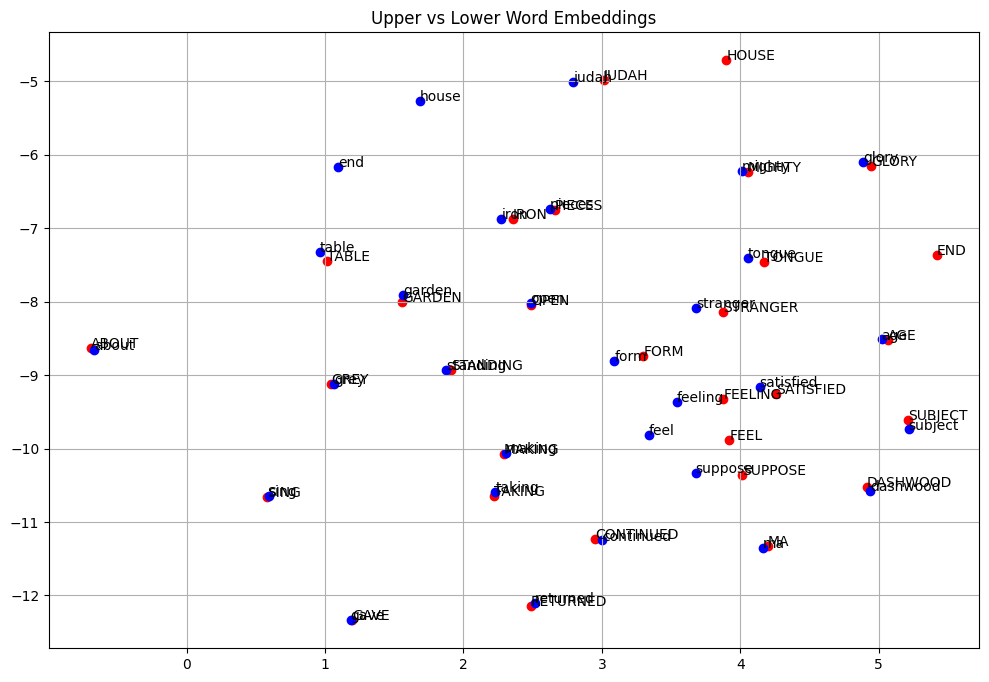

In [ ]:
import nltk
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk.corpus import gutenberg
from gensim.models import Word2Vec
from collections import Counter

nltk.download('gutenberg')
nltk.download('punkt_tab')

all_sentences = list(gutenberg.sents())
random.shuffle(all_sentences)

def clean_sentence(sent):
    return [w.lower() for w in sent if w.isalpha() and len(w) > 1]

cleaned = [clean_sentence(s) for s in all_sentences if len(clean_sentence(s)) > 0]

half = len(cleaned) // 2

lower_corpus = cleaned[:half]
upper_corpus = [[w.upper() for w in sent] for sent in cleaned[half:]]

total_lower_words = sum(len(sent) for sent in lower_corpus)
total_upper_words = sum(len(sent) for sent in upper_corpus)
print(f"Total Lower words: {total_lower_words}")
print(f"Total Upper words: {total_upper_words}")

flat_upper = [w for sent in upper_corpus for w in sent]
flat_lower = [w for sent in lower_corpus for w in sent]

upper_counts = Counter(flat_upper)
common_words = set(w.upper() for w in flat_lower) & set(flat_upper)
top_common = sorted(common_words, key=lambda w: upper_counts[w], reverse=True)[:1000]
D = {w: w.lower() for w in top_common}

def replace_with_translation(sent, D, upper=True):
    if upper:
        # for Upper corpus sentences, replace words in D with lowercase
        return [D[w] if w in D else w for w in sent]
    else:
        # for Lower corpus sentences, replace words in D with uppercase keys
        inv_D = {v: k for k, v in D.items()}
        return [inv_D[w] if w in inv_D else w for w in sent]

translated_lower_corpus = [replace_with_translation(sent, D, upper=False) for sent in lower_corpus]
translated_upper_corpus = [replace_with_translation(sent, D, upper=True) for sent in upper_corpus]

training_corpus = lower_corpus + upper_corpus + translated_lower_corpus + translated_upper_corpus

model = Word2Vec(sentences=training_corpus, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

def average_score(D, model, is_in_D=True, sample_size=500):
    scores = []
    all_vocab = set(model.wv.index_to_key)

    if is_in_D:
        words = [w for w in D.keys() if w in model.wv and D[w] in model.wv]
        if len(words) == 0:
            return 0.0
        words = random.sample(words, min(len(words), sample_size))
        for word in words:
            translation = D[word]
            similar = model.wv.most_similar(word, topn=100)
            ranks = [i for i, (w, _) in enumerate(similar) if w == translation]
            scores.append(1 / (ranks[0] + 1) if ranks else 0.0)
    else:
        words = [w for w in all_vocab if w.isupper() and w.lower() in all_vocab and w not in D]
        if len(words) == 0:
            return 0.0
        words = random.sample(words, min(len(words), sample_size))
        for word in words:
            translation = word.lower()
            similar = model.wv.most_similar(word, topn=100)
            ranks = [i for i, (w, _) in enumerate(similar) if w == translation]
            scores.append(1 / (ranks[0] + 1) if ranks else 0.0)

    return np.mean(scores) if scores else 0.0

score_in_D = average_score(D, model, is_in_D=True)
score_out_D = average_score(D, model, is_in_D=False)

print(f"Average score for words in D: {score_in_D:.4f}")
print(f"Average score for words out of D: {score_out_D:.4f}")

def visualize_embeddings(model, words, title='Embeddings'):
    vectors = [model.wv[w] for w in words if w in model.wv]
    labels = [w for w in words if w in model.wv]

    if len(vectors) < 2:
        print("Not enough words to visualize.")
        return

    reduced = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vectors)-1)).fit_transform(np.array(vectors))

    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y, c='blue' if label.islower() else 'red')
        plt.annotate(label, (x, y))
    plt.title(title)
    plt.grid(True)
    plt.show()

sample_translations = random.sample(list(D.items()), min(30, len(D)))
words_to_plot = [w for pair in sample_translations for w in pair]
visualize_embeddings(model, words_to_plot, title="Upper vs Lower Word Embeddings")


# Task 4: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

In [ ]:
!pip install numpy==1.26.4 --no-deps
!pip install scipy==1.13.1 --no-deps
!pip install gensim==4.3.3 --no-deps


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy
from gensim.models import KeyedVectors

print("All imports succeeded.")
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)


All imports succeeded.
NumPy version: 1.26.4
SciPy version: 1.13.1


# 1

In [ ]:
import gensim.downloader as api

word2vec_vectors = api.load('word2vec-google-news-300')
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

print("Word2Vec and FastText models loaded successfully!\n")


basic_words = ['computer', 'cat', 'love', 'king', 'apple']

def print_similar_words(model, model_name, words, topn=5):
    print(f"Similar words using {model_name} model:\n")
    for word in words:
        if word in model:
            similar = model.most_similar(word, topn=topn)
            print(f"Most similar words to '{word}':")
            for sim_word, score in similar:
                print(f"  {sim_word}: {score:.4f}")
            print()
        else:
            print(f"Word '{word}' not in vocabulary of {model_name}.\n")


print_similar_words(word2vec_vectors, "Word2Vec", basic_words)
print_similar_words(fasttext_vectors, "FastText", basic_words)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
Word2Vec and FastText models loaded successfully!

Similar words using Word2Vec model:

Most similar words to 'computer':
  computers: 0.7979
  laptop: 0.6640
  laptop_computer: 0.6549
  Computer: 0.6473
  com_puter: 0.6082

Most similar words to 'cat':
  cats: 0.8099
  dog: 0.7609
  kitten: 0.7465
  feline: 0.7326
  beagle: 0.7151

Most similar words to 'love':
  loved: 0.6908
  adore: 0.6817
  loves: 0.6619
  passion: 0.6101
  hate: 0.6004

Most similar words to 'king':
  kings: 0.7138
  queen: 0.6511
  monarch: 0.6413
  crown_prince: 0.6204
  prince: 0.6160

Most similar words to 'apple':
  apples: 0.7204
  pear: 0.6451
  fruit: 0.6410
  berry: 0.6302
  pears: 0.6134

Similar words using FastText model:

Most similar words to 'computer':
  computers: 0.8473
  non-computer: 0.8157
  mini-computer: 0.8100
  micro-co

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

analogies = [
    ('man', 'king', 'woman', 'queen'),
    ('france', 'paris', 'germany', 'berlin'),
    ('man', 'father', 'woman', 'mother'),
    ('man', 'dad', 'woman', 'mom'),
    ('boy', 'brother', 'girl', 'sister'),
    ('prince', 'king', 'princess', 'queen'),
    ('dog', 'puppy', 'cat', 'kitten'),
    ('car', 'driver', 'plane', 'pilot'),
    ('boy', 'son', 'girl', 'daughter'),
    ('japan', 'tokyo', 'china', 'beijing'),
    ('dog', 'bark', 'cat', 'meow')
]

def analogy_accuracy(model, analogies, topn=1, verbose=True):
    correct = 0
    total = 0

    vocab = set(model.key_to_index)
    vectors = np.array([model[word] for word in vocab])
    vocab_list = list(vocab)

    for a, b, c, expected in analogies:
        if all(w in vocab for w in [a, b, c, expected]):
            total += 1

            #  b - a + c
            target_vector = model[b] - model[a] + model[c]

            # cosine similarity with all vocab vectors
            sims = cosine_similarity([target_vector], vectors)[0]
            best_indices = sims.argsort()[::-1]

            found = False
            for idx in best_indices:
                predicted = vocab_list[idx]
                if predicted in {a, b, c}:
                    continue
                if predicted == expected:
                    correct += 1
                    found = True
                elif topn > 1:
                    continue  # if topn > 1, we could collect more
                break

            if not found and verbose:
                print(f"Missed: '{a}' is to '{b}' as '{c}' is to '{predicted}' (expected '{expected}')")
        else:
            if verbose:
                print(f"Skipping analogy: {a}, {b}, {c}, {expected} - word(s) not in vocab")

    return correct / total if total else 0.0



print("Evaluating Word2Vec:")
word2vec_vectors = api.load('word2vec-google-news-300')
word2vec_accuracy = analogy_accuracy(word2vec_vectors, analogies)
del word2vec_vectors
print(f"Word2Vec analogy accuracy: {word2vec_accuracy * 100:.2f}%\n")

print("Evaluating FastText:")
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')
fasttext_accuracy = analogy_accuracy(fasttext_vectors, analogies)
del fasttext_vectors
print(f"FastText analogy accuracy: {fasttext_accuracy * 100:.2f}%")


Evaluating Word2Vec:
Missed: 'car' is to 'driver' as 'plane' is to 'clipped_treetops' (expected 'pilot')
Missed: 'japan' is to 'tokyo' as 'china' is to 'dinnerware' (expected 'beijing')
Missed: 'dog' is to 'bark' as 'cat' is to 'frass' (expected 'meow')
Word2Vec analogy accuracy: 72.73%

Evaluating FastText:
Missed: 'car' is to 'driver' as 'plane' is to 'copilot' (expected 'pilot')
Missed: 'japan' is to 'tokyo' as 'china' is to 'chinatown' (expected 'beijing')
Missed: 'dog' is to 'bark' as 'cat' is to 'shagbark' (expected 'meow')
FastText analogy accuracy: 72.73%


# 2


In [ ]:
pip install fasttext

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Cosine Similarities after Procrustes alignment:
   king -> król      : 0.9908
  queen -> królowa   : 0.9915
    man -> mężczyzna : 0.9862
  woman -> kobieta   : 0.9957
 father -> ojciec    : 0.9863
 mother -> matka     : 0.9847
    cat -> kot       : 0.9968
    dog -> pies      : 0.9952
    car -> samochód  : 0.9903
  house -> dom       : 0.9904


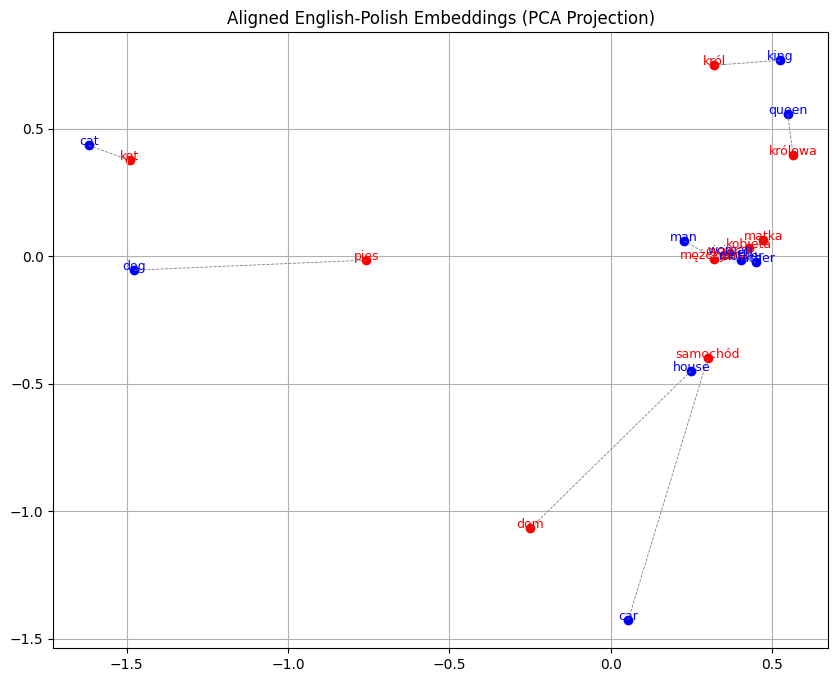

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import fasttext
from scipy.linalg import orthogonal_procrustes
from sklearn.decomposition import PCA

bilingual_dictionary = [
    ('king', 'król'),
    ('queen', 'królowa'),
    ('man', 'mężczyzna'),
    ('woman', 'kobieta'),
    ('father', 'ojciec'),
    ('mother', 'matka'),
    ('cat', 'kot'),
    ('dog', 'pies'),
    ('car', 'samochód'),
    ('house', 'dom'),
]


en_model_path = hf_hub_download("facebook/fasttext-en-vectors", "model.bin")

en_model = fasttext.load_model(en_model_path)
en_vectors = []
for eng, _ in bilingual_dictionary:
    en_vectors.append(en_model.get_word_vector(eng))
del en_model

pl_model_path = hf_hub_download("facebook/fasttext-pl-vectors", "model.bin")
pl_model = fasttext.load_model(pl_model_path)
pl_vectors = []
for _, pol in bilingual_dictionary:
    pl_vectors.append(pl_model.get_word_vector(pol))
del pl_model


X = np.vstack(en_vectors)
Y = np.vstack(pl_vectors)


W, _ = orthogonal_procrustes(Y, X)
Y_aligned = Y @ W


cos_sim = np.sum(X * Y_aligned, axis=1) / (
    np.linalg.norm(X, axis=1) * np.linalg.norm(Y_aligned, axis=1)
)

print("\nCosine Similarities after Procrustes alignment:")
for i, (eng, pol) in enumerate(bilingual_dictionary):
    print(f"{eng:>7s} -> {pol:<10s}: {cos_sim[i]:.4f}")

pca = PCA(n_components=2)
all_points_2d = pca.fit_transform(np.vstack([X, Y_aligned]))

plt.figure(figsize=(10, 8))
for i, (eng, pol) in enumerate(bilingual_dictionary):
    xi, yi = all_points_2d[i]
    xj, yj = all_points_2d[i + len(bilingual_dictionary)]

    plt.scatter(xi, yi, color='blue')
    plt.text(xi, yi, eng, fontsize=9, color='blue', ha='center')

    plt.scatter(xj, yj, color='red')
    plt.text(xj, yj, pol, fontsize=9, color='red', ha='center')

    plt.plot([xi, xj], [yi, yj], 'gray', linestyle='--', linewidth=0.6)

plt.title("Aligned English-Polish Embeddings (PCA Projection)")
plt.grid(True)
plt.show()


# 3

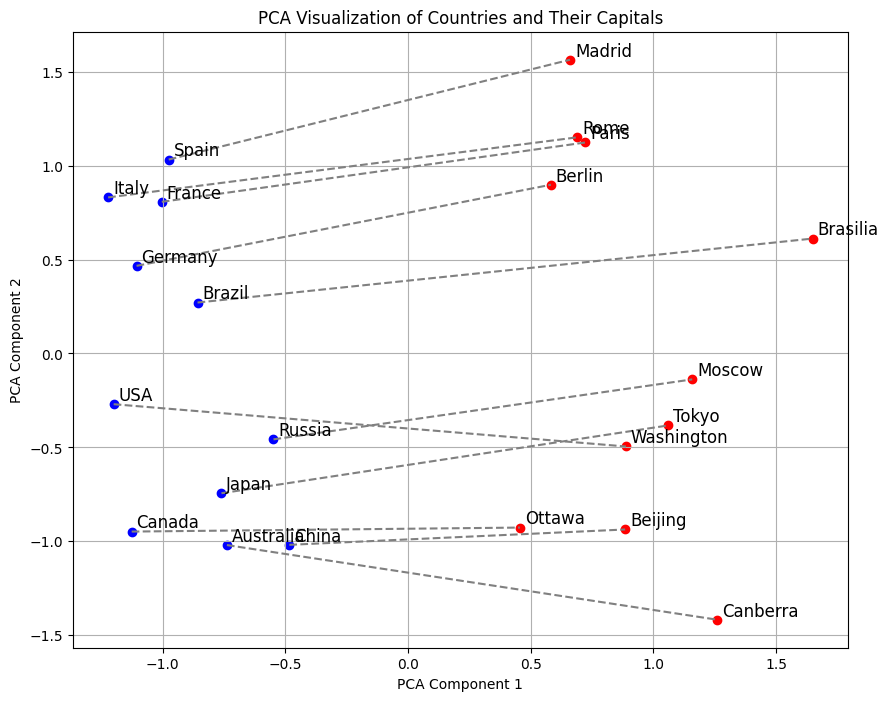

In [ ]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

word2vec_vectors = api.load('word2vec-google-news-300')

countries_and_capitals = [
    ('USA', 'Washington'),
    ('France', 'Paris'),
    ('Germany', 'Berlin'),
    ('Italy', 'Rome'),
    ('Spain', 'Madrid'),
    ('Australia', 'Canberra'),
    ('Japan', 'Tokyo'),
    ('Canada', 'Ottawa'),
    ('Brazil', 'Brasilia'),
    ('Russia', 'Moscow'),
    ('China', 'Beijing')
]


countries_embeddings = [word2vec_vectors[country] for country, _ in countries_and_capitals]
capitals_embeddings = [word2vec_vectors[capital] for _, capital in countries_and_capitals]


all_embeddings = countries_embeddings + capitals_embeddings

pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)


countries_pca = pca_result[:len(countries_and_capitals)]
capitals_pca = pca_result[len(countries_and_capitals):]

plt.figure(figsize=(10, 8))

for i, (country, _) in enumerate(countries_and_capitals):
    plt.scatter(countries_pca[i, 0], countries_pca[i, 1], color='blue')
    plt.text(countries_pca[i, 0] + 0.02, countries_pca[i, 1] + 0.02, country, fontsize=12)

for i, (_, capital) in enumerate(countries_and_capitals):
    plt.scatter(capitals_pca[i, 0], capitals_pca[i, 1], color='red')
    plt.text(capitals_pca[i, 0] + 0.02, capitals_pca[i, 1] + 0.02, capital, fontsize=12)


for i in range(len(countries_and_capitals)):
    plt.plot([countries_pca[i, 0], capitals_pca[i, 0]],
             [countries_pca[i, 1], capitals_pca[i, 1]], color='gray', linestyle='--')

plt.title("PCA Visualization of Countries and Their Capitals")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


# 4

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


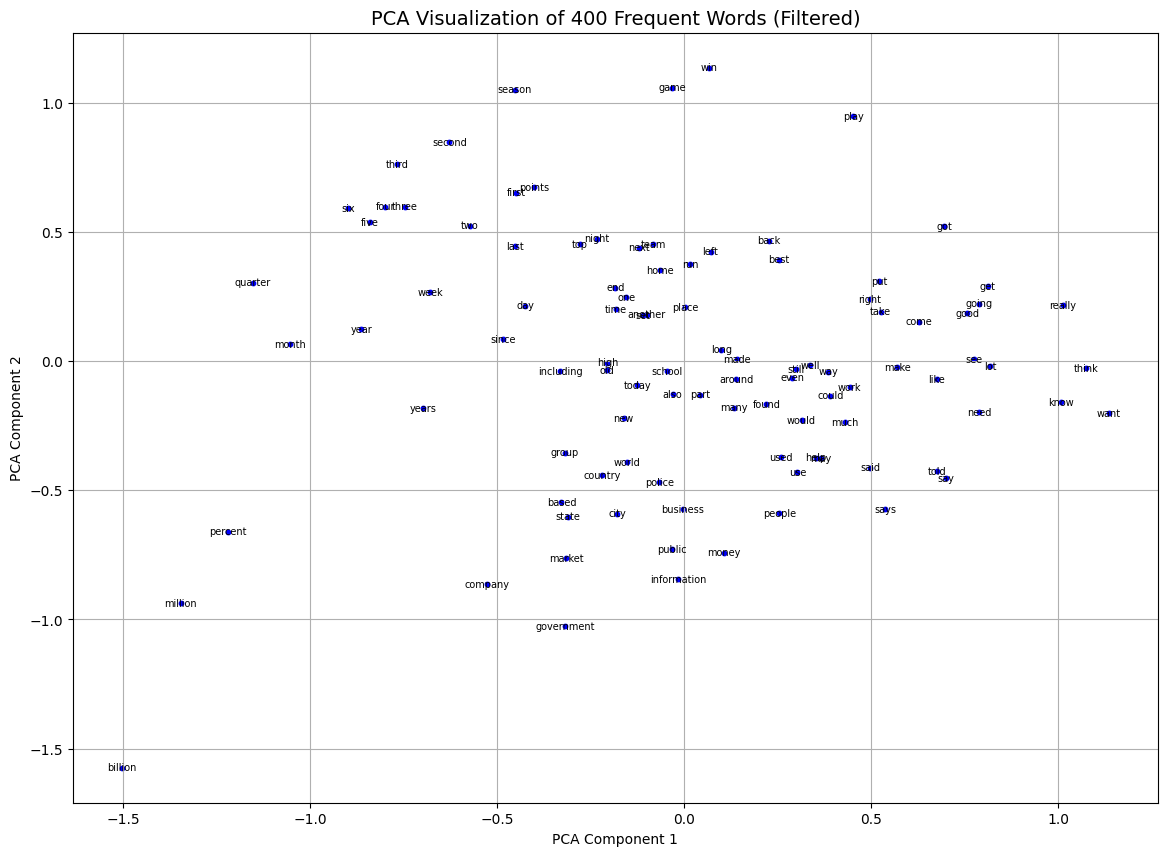

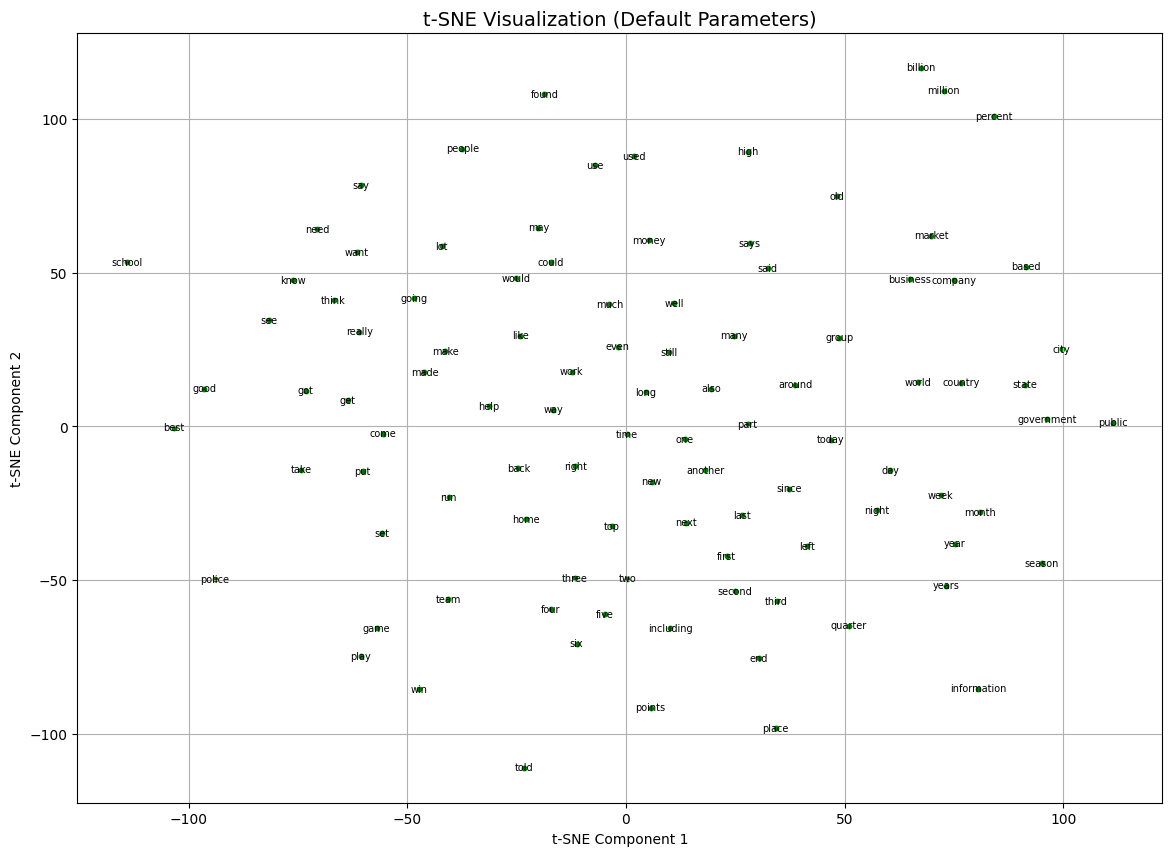

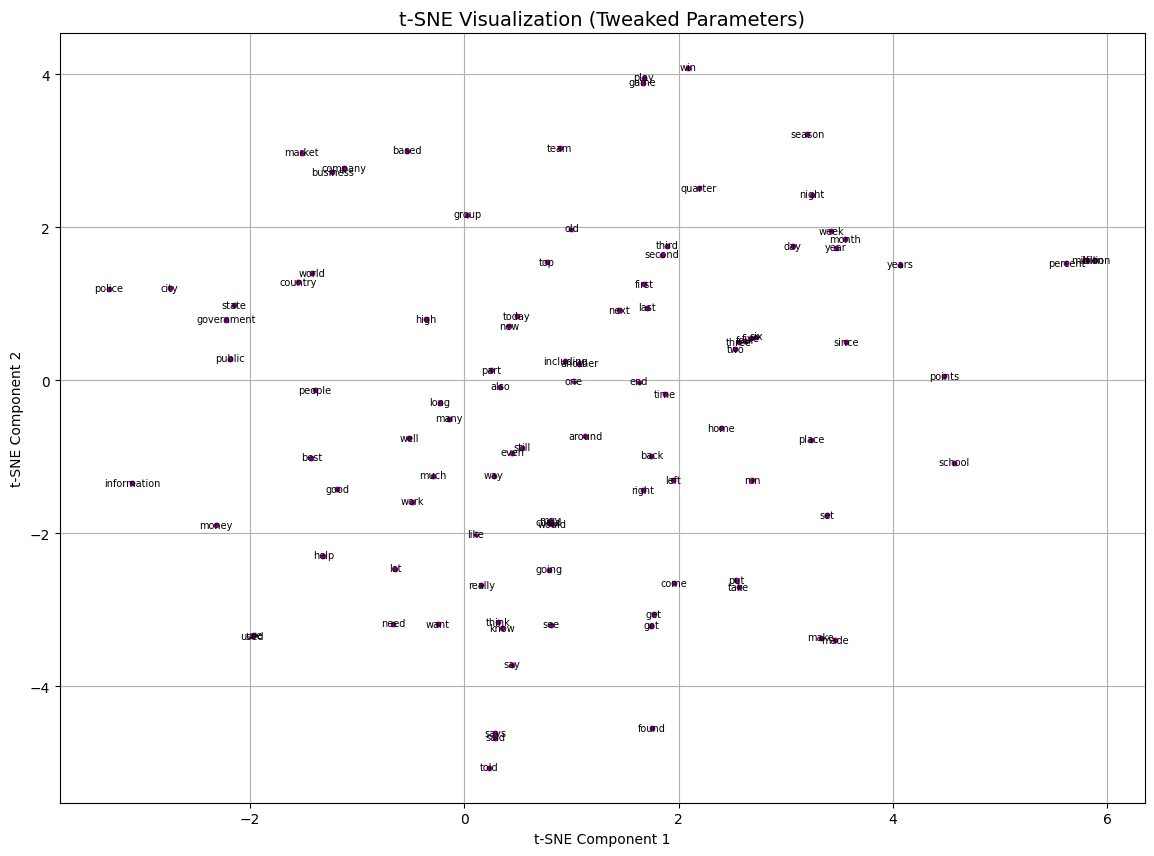

In [ ]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import nltk
import string


nltk.download('stopwords')

word2vec_vectors = api.load('word2vec-google-news-300')

# Get 2000 most frequent words
most_frequent_words = list(word2vec_vectors.key_to_index.keys())[:2000]

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def is_valid(word):
    return (
        word.isalpha() and
        word.lower() not in stop_words and
        word.lower() not in punctuation and
        len(word) >= 3 and
        word.islower()
    )

# Filter + truncate to 400
filtered_words = [word for word in most_frequent_words if is_valid(word)]
filtered_words = filtered_words[:100]


word_embeddings = np.array([word2vec_vectors[word] for word in filtered_words])


pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

plt.figure(figsize=(14, 10))
for i, word in enumerate(filtered_words):
    x, y = pca_result[i]
    plt.scatter(x, y, color='blue', s=10)
    plt.text(x, y, word, fontsize=7, ha='center', va='center')
plt.title("PCA Visualization of 400 Frequent Words (Filtered)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


tsne_default = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    init='pca'
)
tsne_result_default = tsne_default.fit_transform(word_embeddings)

plt.figure(figsize=(14, 10))
for i, word in enumerate(filtered_words):
    x, y = tsne_result_default[i]
    plt.scatter(x, y, color='green', s=10)
    plt.text(x, y, word, fontsize=7, ha='center', va='center')
plt.title("t-SNE Visualization (Default Parameters)", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


tsne_tweaked = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=150,
    max_iter=2000,
    init='pca',
    random_state=42
)
tsne_result_tweaked = tsne_tweaked.fit_transform(word_embeddings)

plt.figure(figsize=(14, 10))
for i, word in enumerate(filtered_words):
    x, y = tsne_result_tweaked[i]
    plt.scatter(x, y, color='purple', s=10)
    plt.text(x, y, word, fontsize=7, ha='center', va='center')
plt.title("t-SNE Visualization (Tweaked Parameters)", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


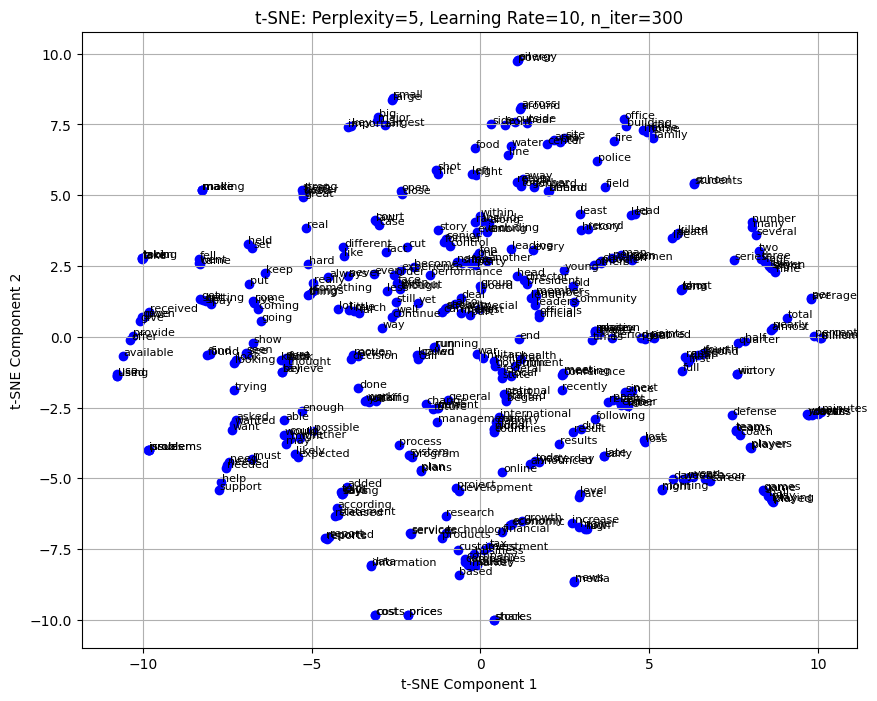

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


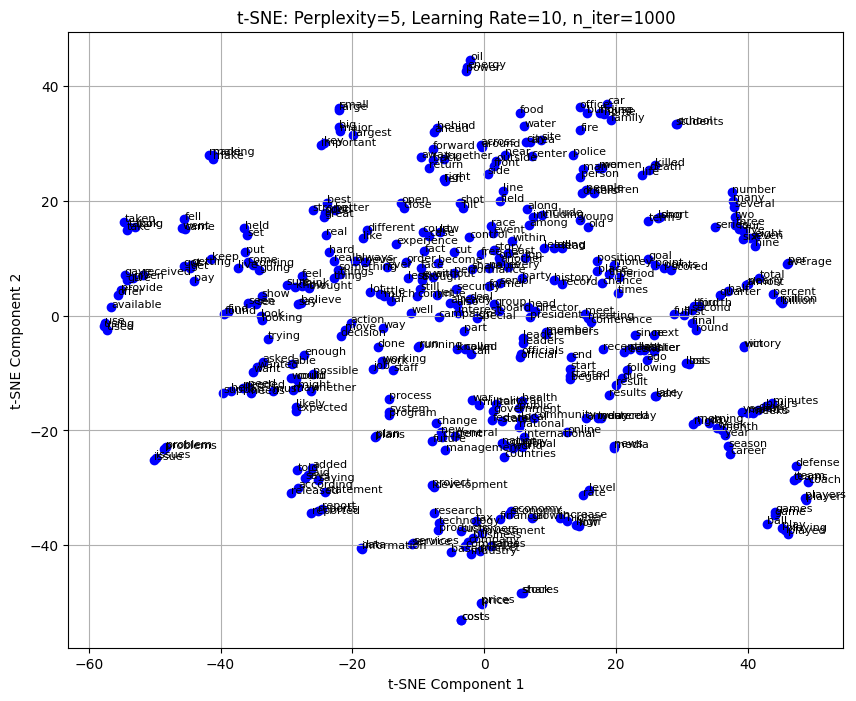

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


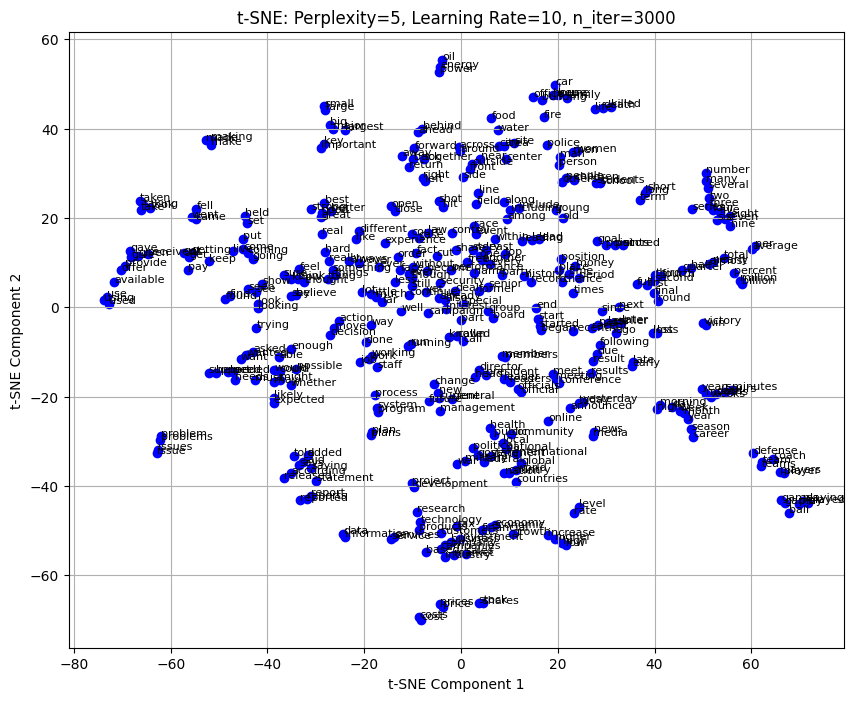

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


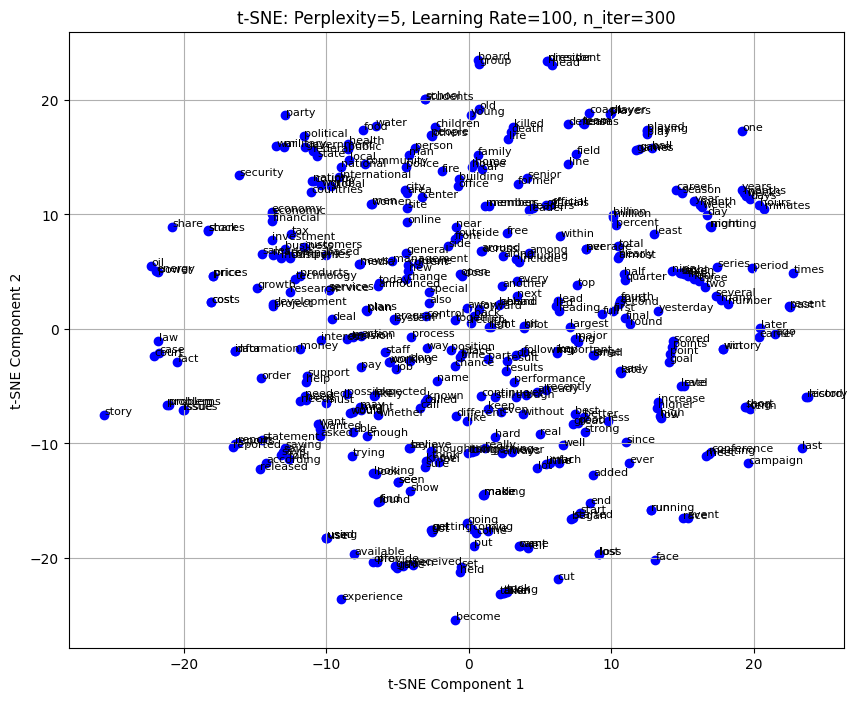

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


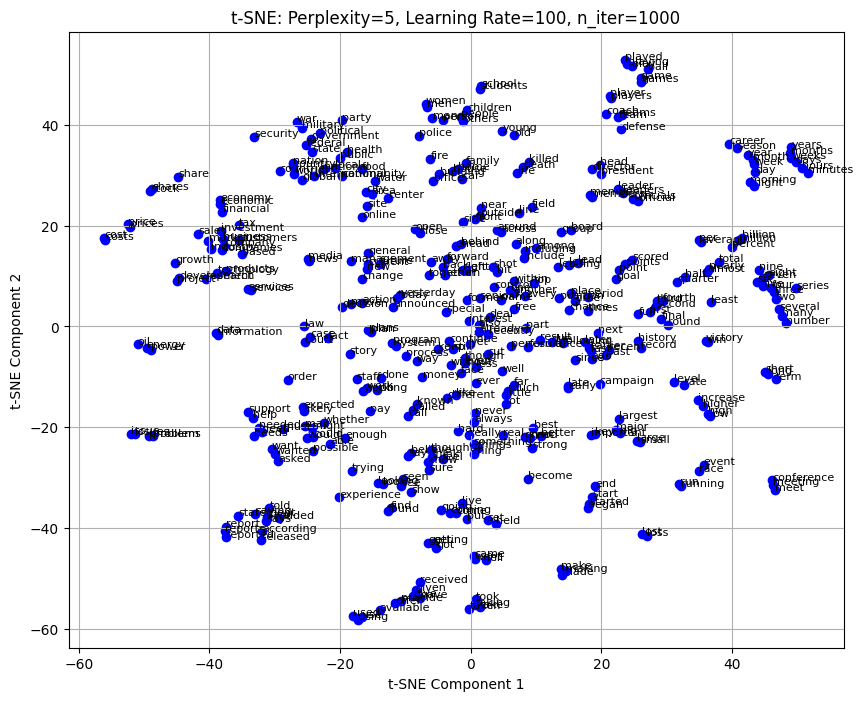

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


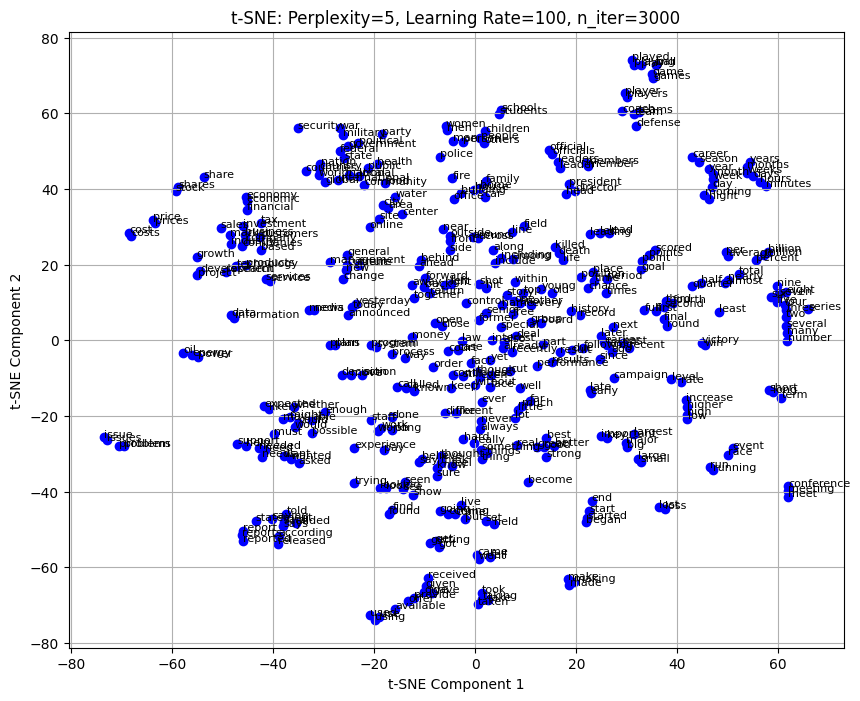

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


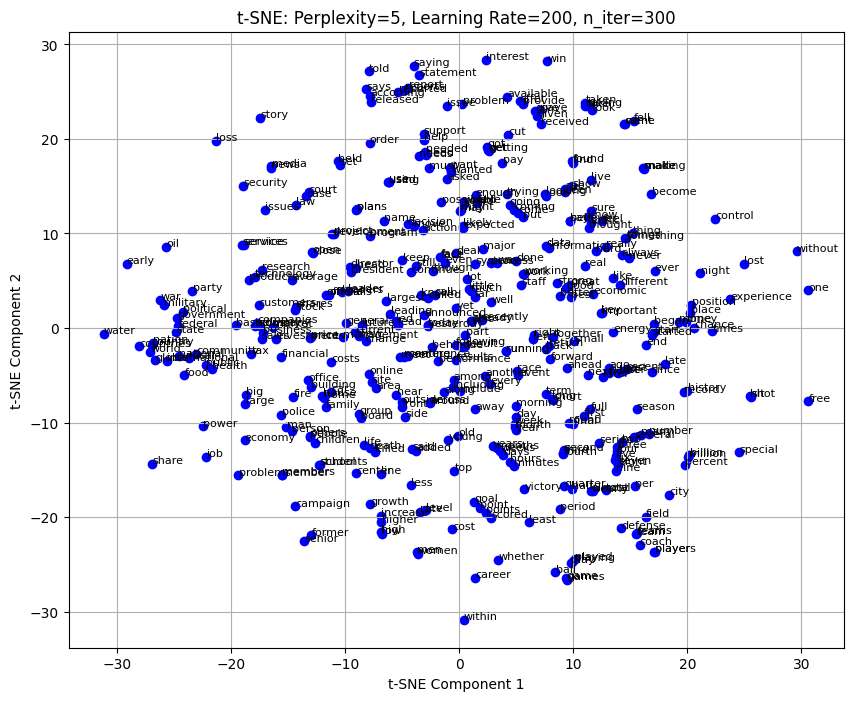

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


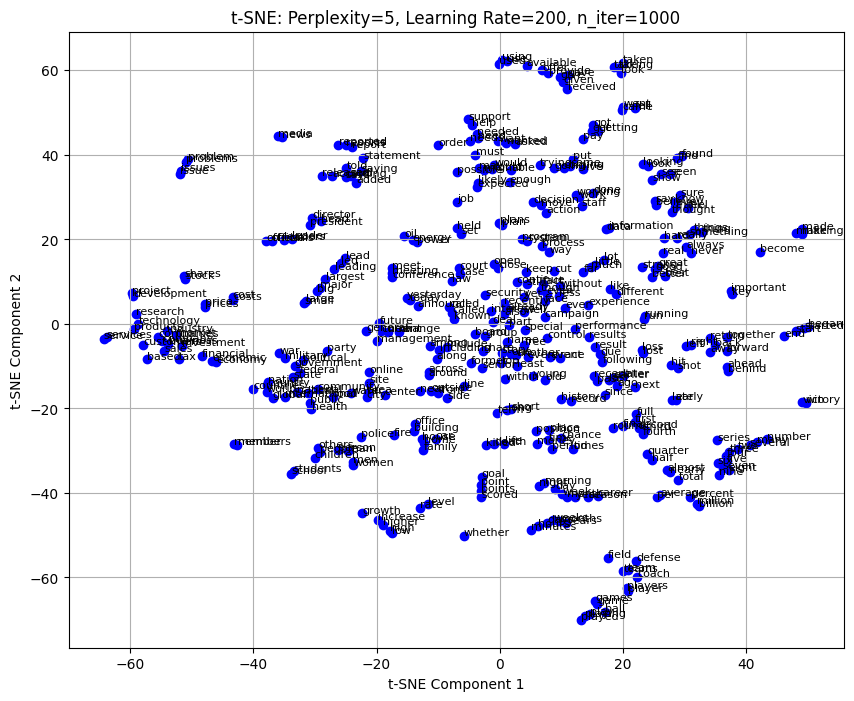

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


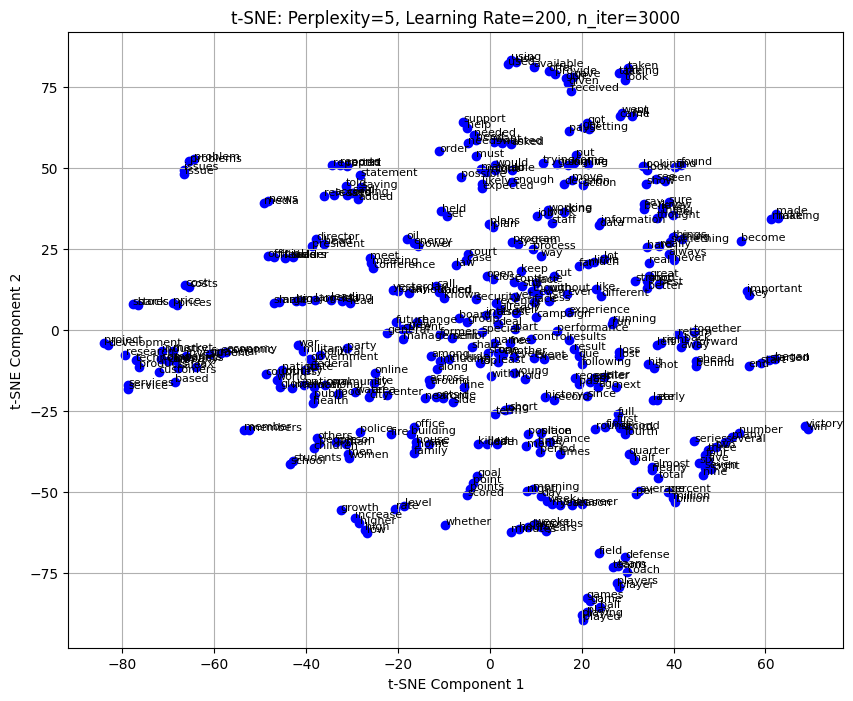

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


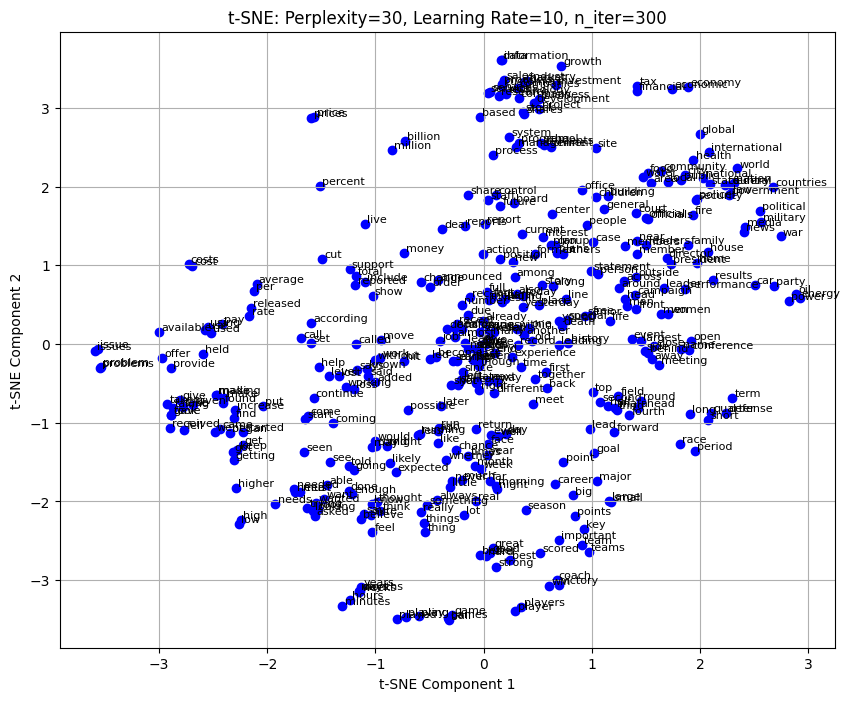

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


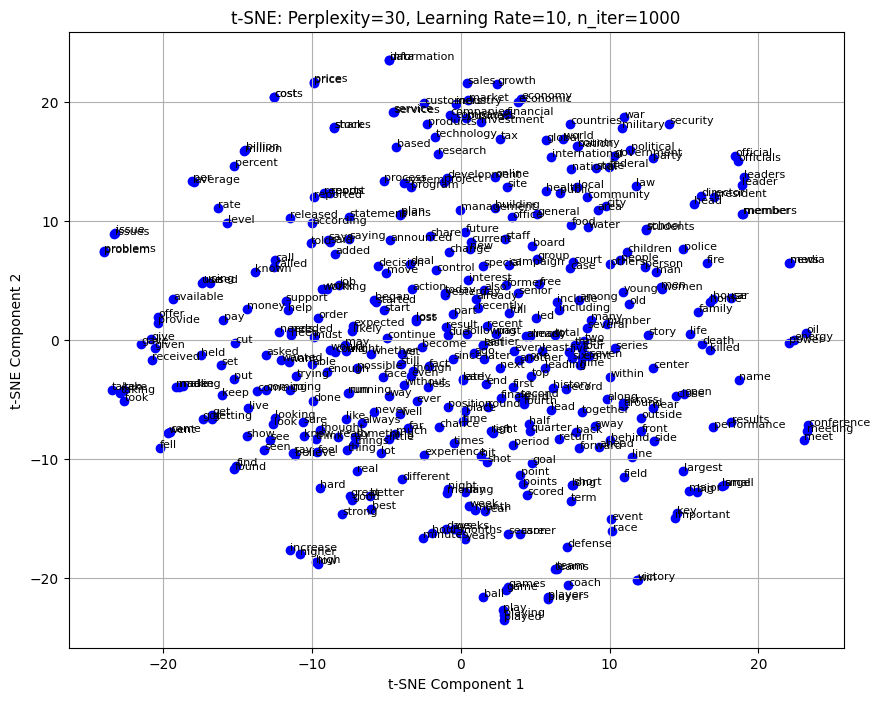

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


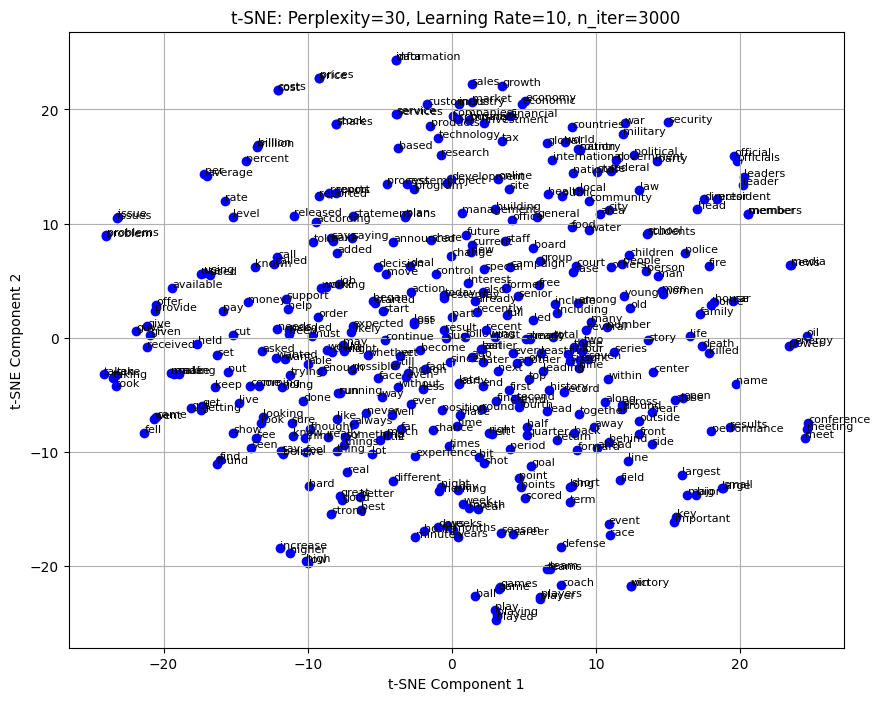

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


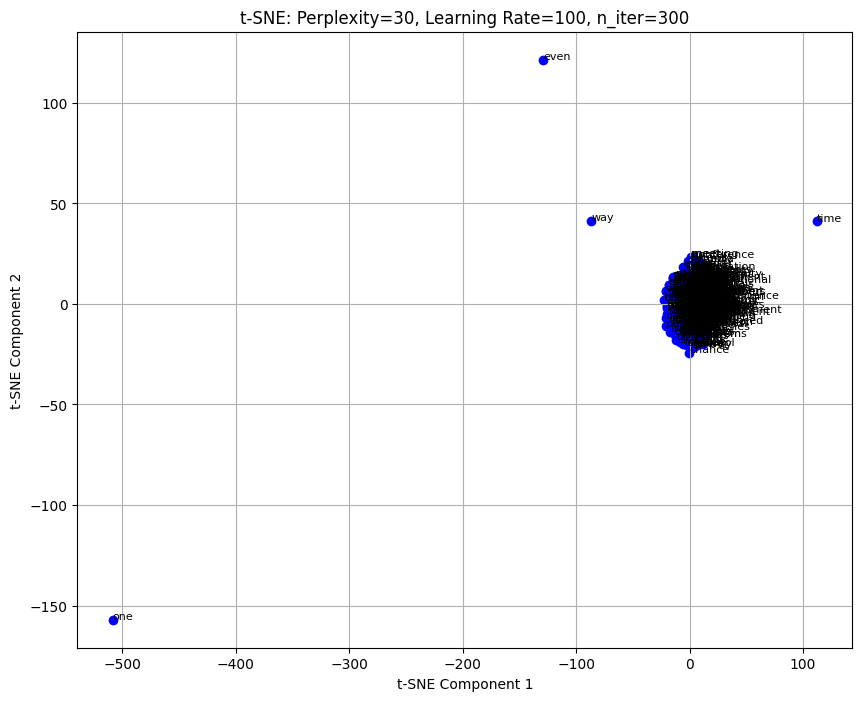

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


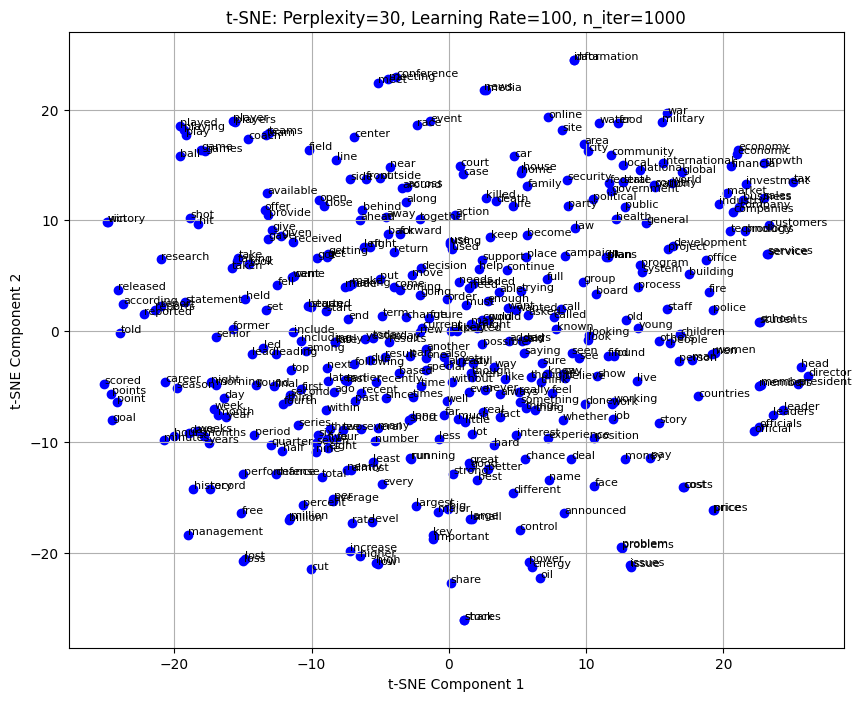

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


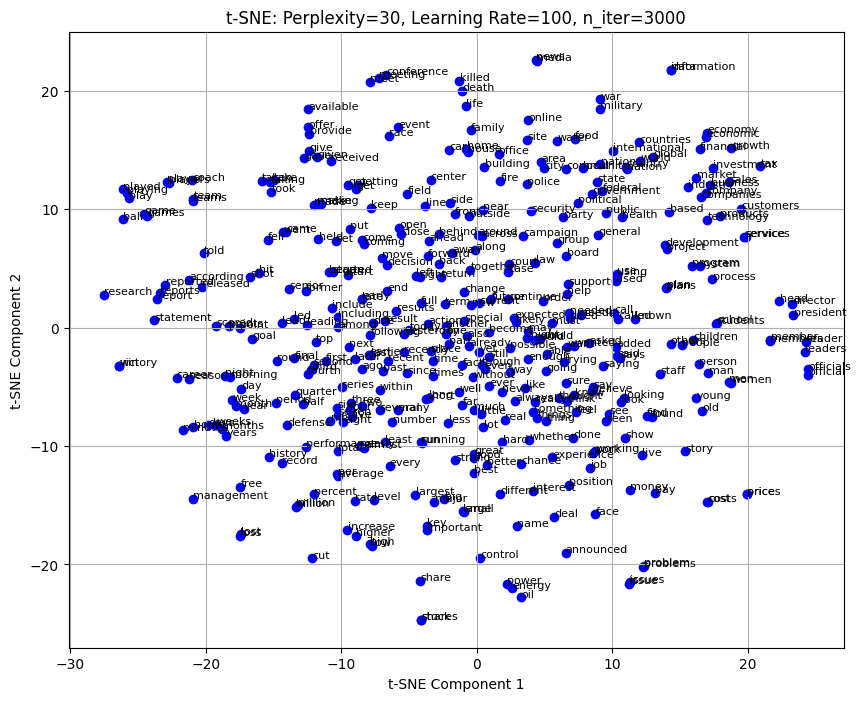

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


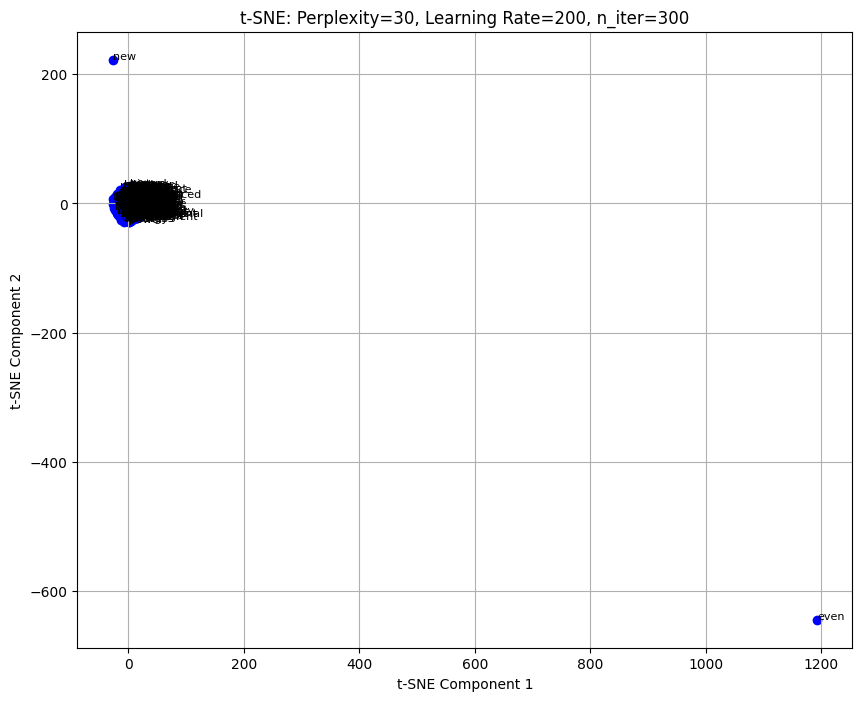

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


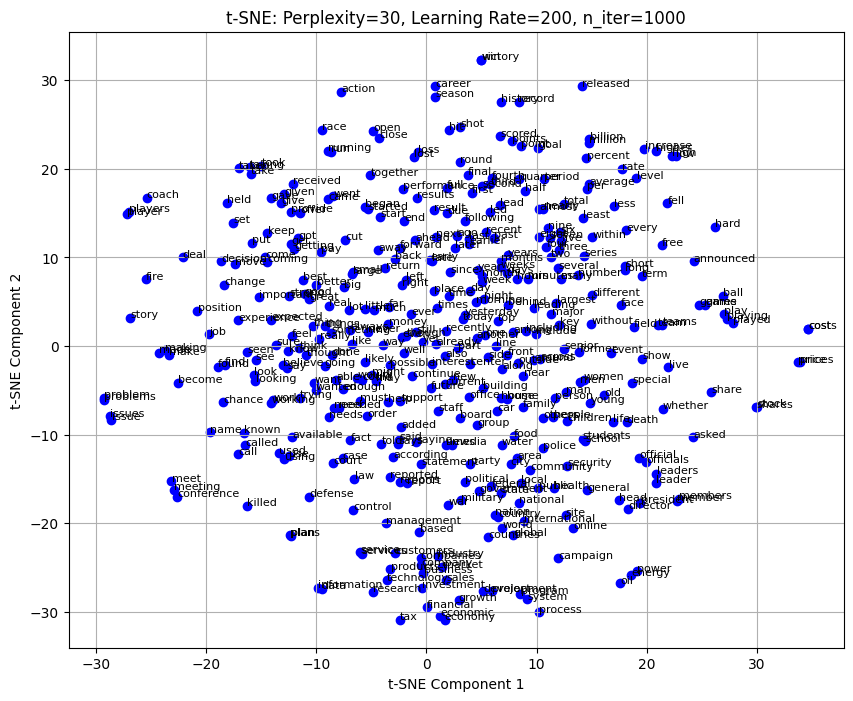

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


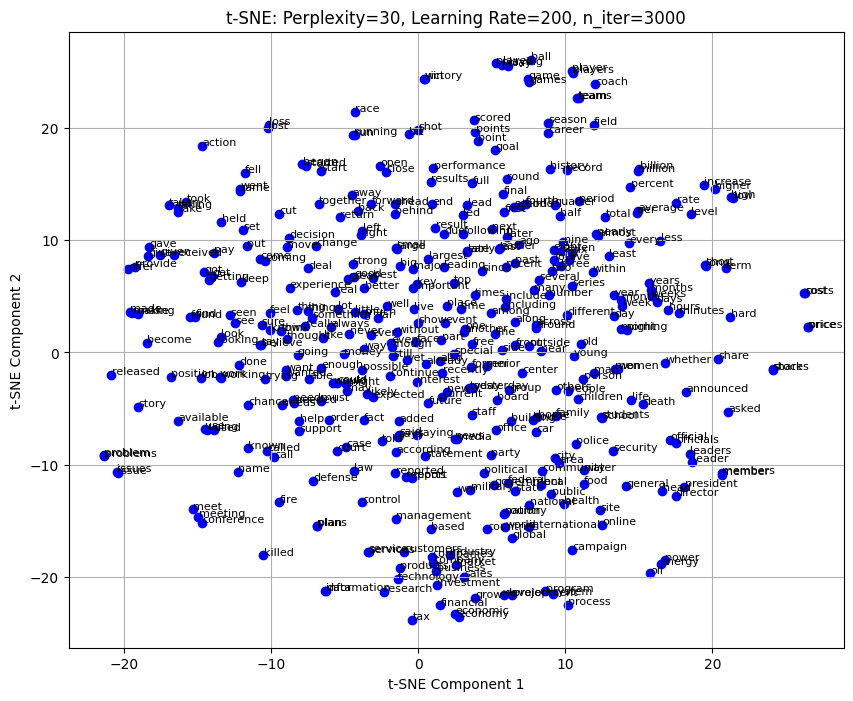

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


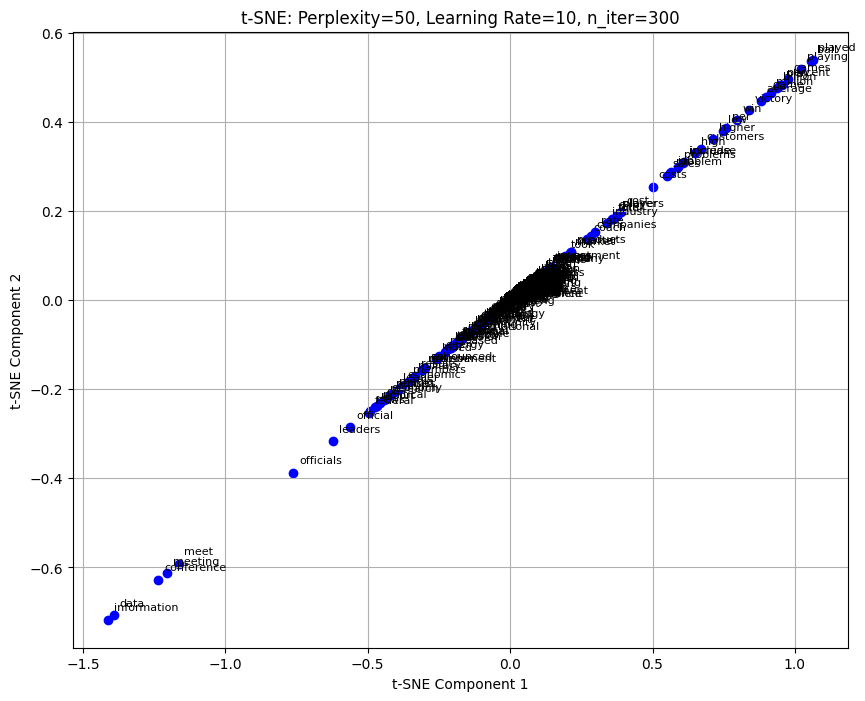

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


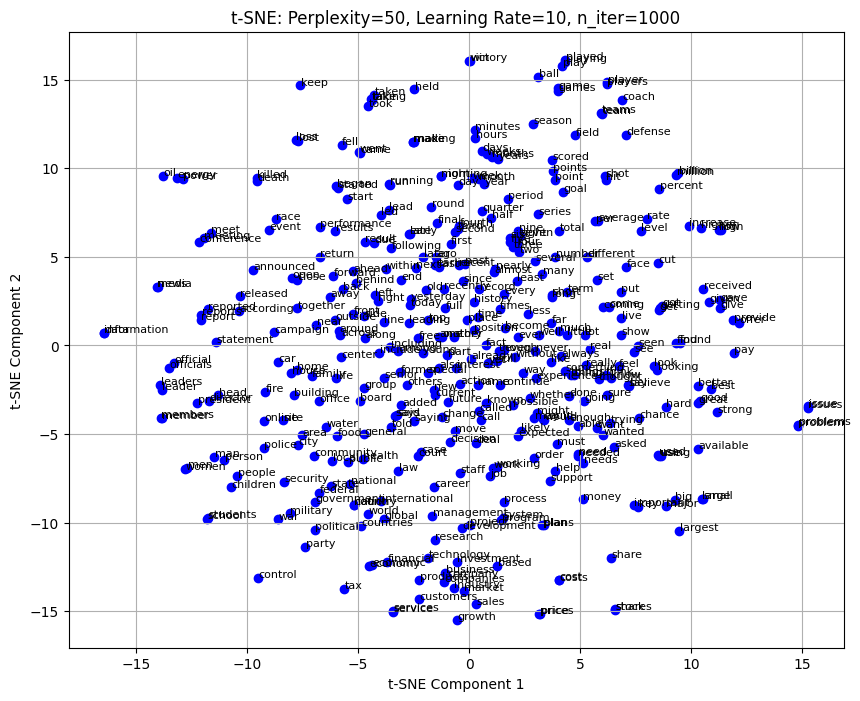

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


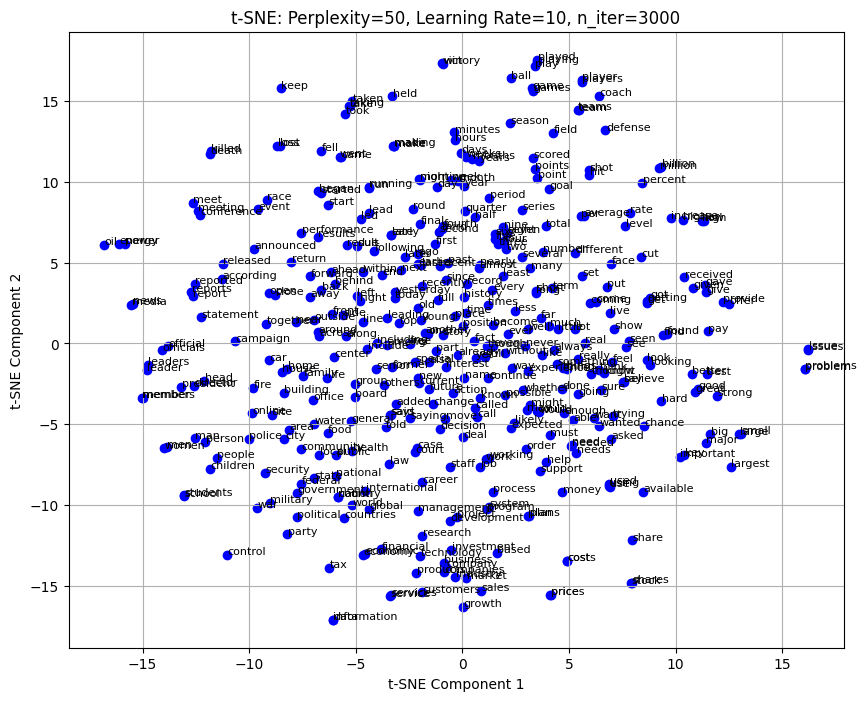

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


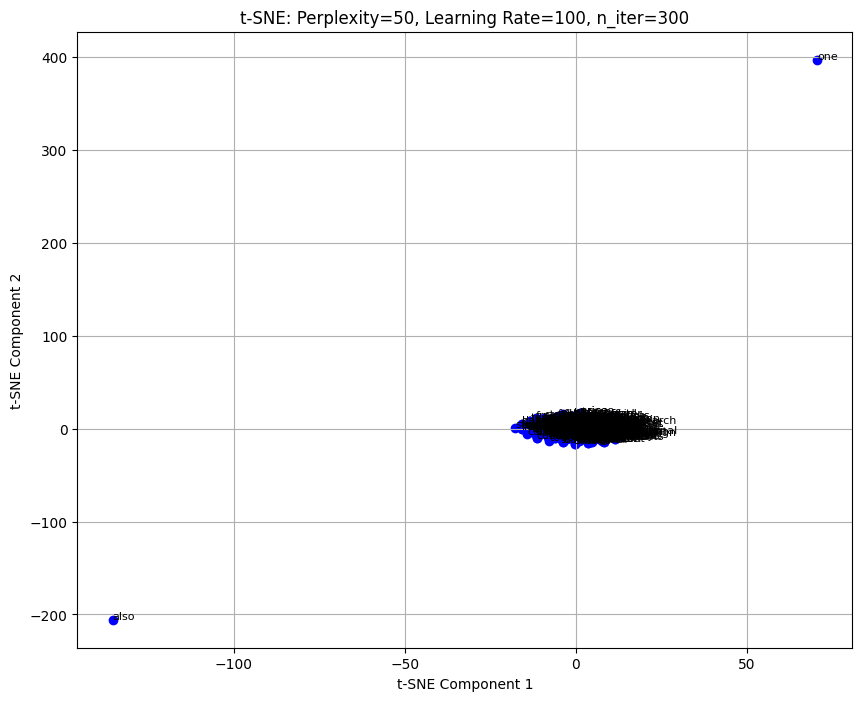

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


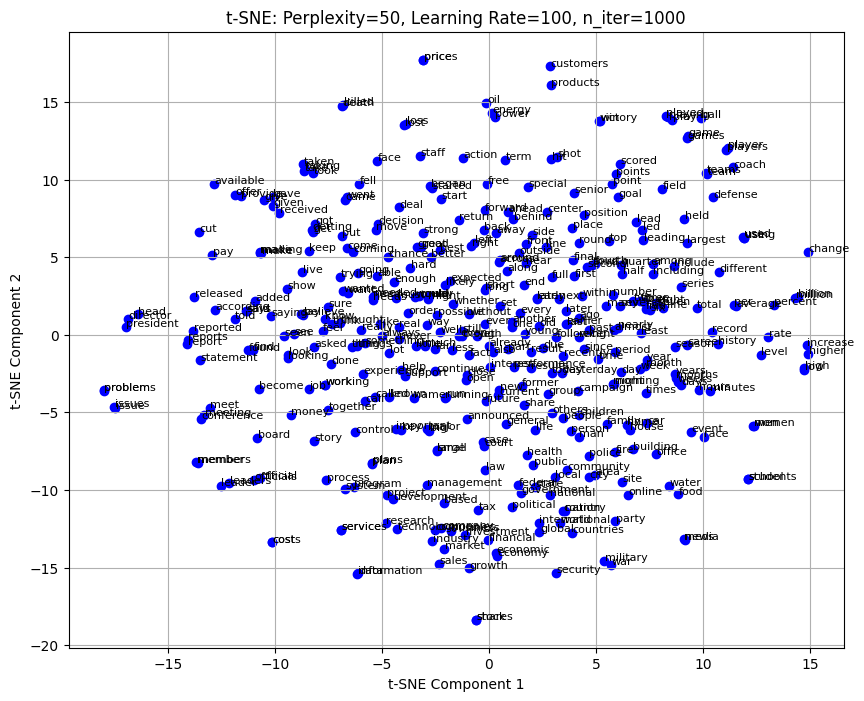

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


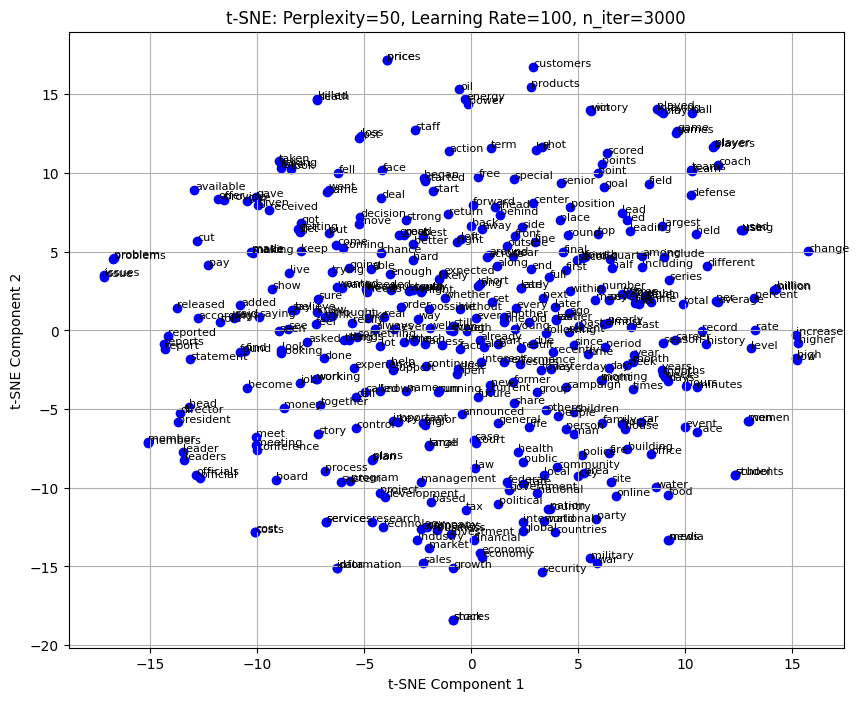

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


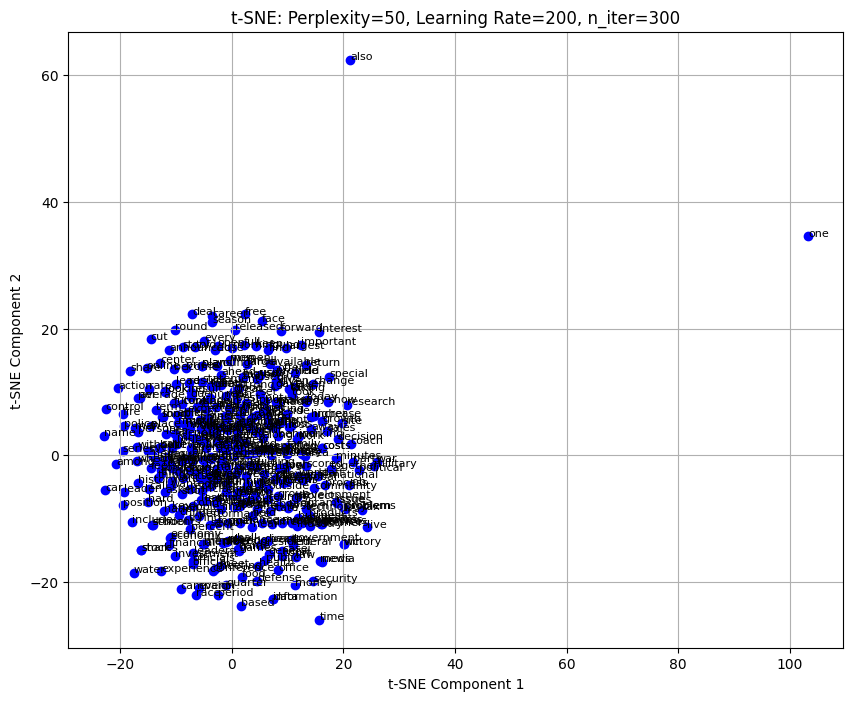

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


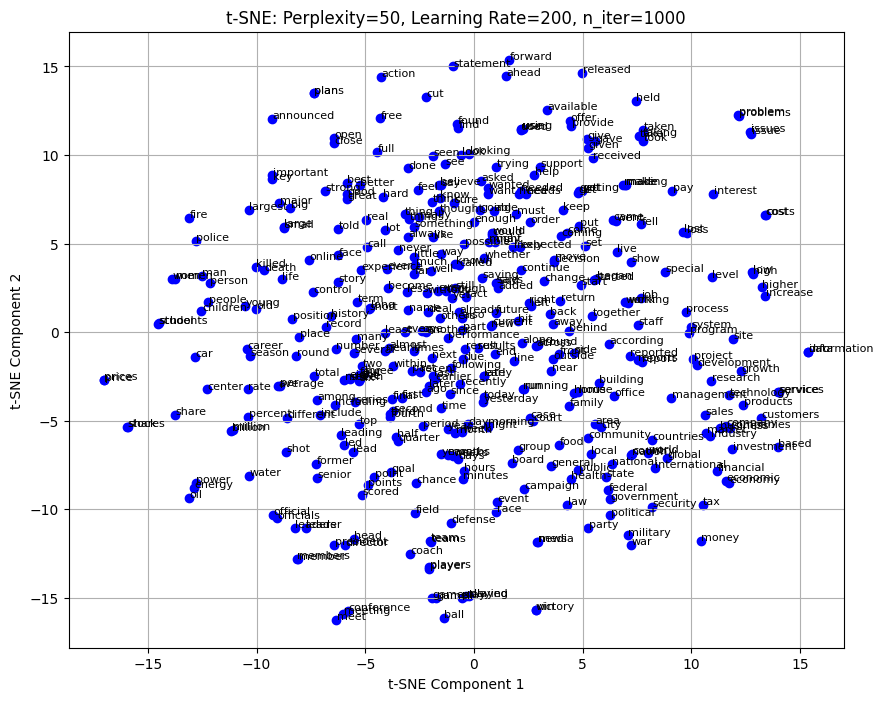

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


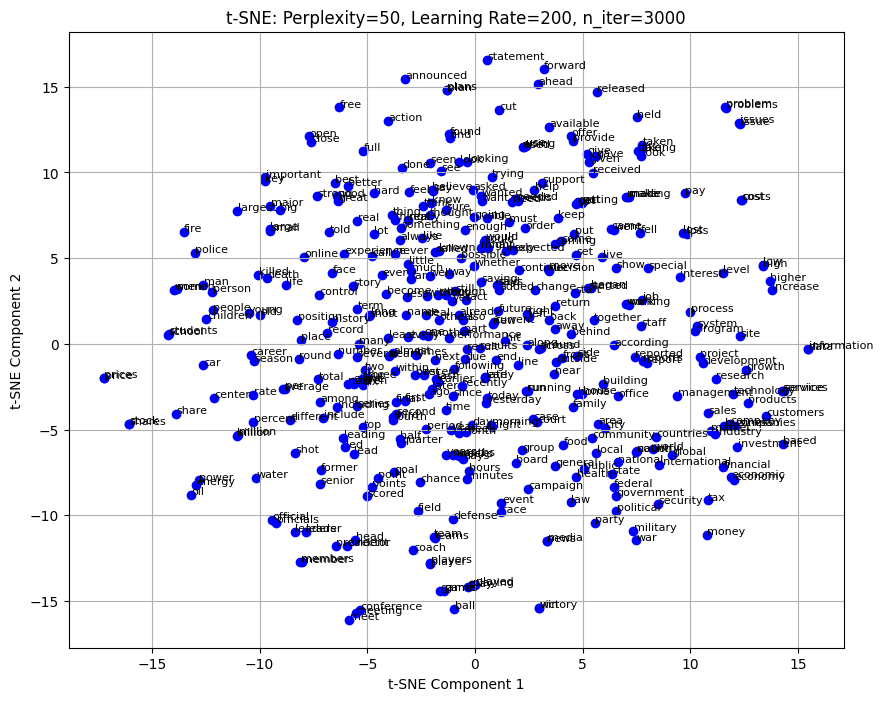

In [ ]:
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


perplexities = [5, 30, 50]
learning_rates = [10, 100, 200]
n_iter_values = [300, 1000, 3000]


param_combinations = list(itertools.product(perplexities, learning_rates, n_iter_values))


for perplexity, learning_rate, n_iter in param_combinations:

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_result = tsne.fit_transform(word_embeddings)


    plt.figure(figsize=(10, 8))
    for i, word in enumerate(filtered_words):
        plt.scatter(tsne_result[i, 0], tsne_result[i, 1], color='blue')
        plt.text(tsne_result[i, 0] + 0.02, tsne_result[i, 1] + 0.02, word, fontsize=8)
    plt.title(f"t-SNE: Perplexity={perplexity}, Learning Rate={learning_rate}, n_iter={n_iter}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()


# Task 5: TBA [5p]

Build a basic language model using a publicly available text dataset. You'll experiment with RNN-based architectures (Simple RNN, LSTM, GRU) to learn how they model sequences.

### **Part 1: Dataset Download & Preparation (1 point)**

**Tasks:**

* Download a publicly available dataset, e.g., *Alice’s Adventures in Wonderland* from Project Gutenberg.
  * Use requests or a dataset API like torchtext.datasets.
* Preprocess the text:
  * Lowercase, remove non-alphabetic characters.
  * Tokenize into words (use nltk or spaCy).
  * Build a vocabulary, keeping frequent words (e.g., top 10k).
* Use **pretrained word embeddings** (e.g., GloVe 100d or FastText):
  * Load with torchtext.vocab, gensim, or similar.
  * Initialize the embedding layer with pretrained vectors.


### **Part 2: Build a Recurrent Language Model (1 point)**

**Tasks:**

* Implement a word-level language model using:
  * Pretrained embedding layer (frozen or trainable).
  * A single-layer **Simple RNN**.
  * A fully connected output layer with softmax.

### **Part 3: Train the Model (1 point)**

**Tasks:**

* Use cross-entropy loss.
* Predict the next word from a sequence.
* Use teacher forcing and batching.
* Plot training loss over time.

### **Part 4: Generate Text (1 point)**

**Tasks:**

* Given a seed sequence, generate text of specified length.
* Use **temperature sampling** to vary creativity.
* Try different temperatures and compare.

### **Part 5: Evaluation & Reflection (1 point) -> W&B report**

**Tasks:**

* Evaluate model outputs: does it learn sentence structure?
* Reflect on limitations of the Simple RNN and its behavior on longer sequences.

### **Bonus Section (Up to +2 Points): Model Comparison**

Compare the performance of three models:


1. Simple RNN
2. LSTM
3. GRU

**Tasks:**

* Implement the same model architecture but switch out the recurrent layer.
* Train all three models under the same conditions.
* Record and compare:
  * Training time
  * Final loss
  * Generated text quality
* (Optional) Add dropout to recurrent layers and observe effects.
* Summarize findings in a table or chart.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Loading corpus...
Loading GloVe vectors...
Training...


100%|██████████| 412/412 [00:03<00:00, 106.69it/s]


Epoch 1: Loss = 5.8578


100%|██████████| 412/412 [00:03<00:00, 109.03it/s]


Epoch 2: Loss = 4.6170


100%|██████████| 412/412 [00:04<00:00, 102.87it/s]


Epoch 3: Loss = 3.6543


100%|██████████| 412/412 [00:03<00:00, 108.63it/s]


Epoch 4: Loss = 2.8355


100%|██████████| 412/412 [00:03<00:00, 108.63it/s]


Epoch 5: Loss = 2.1726


100%|██████████| 412/412 [00:04<00:00, 101.61it/s]


Epoch 6: Loss = 1.6803


100%|██████████| 412/412 [00:03<00:00, 108.10it/s]


Epoch 7: Loss = 1.3365


100%|██████████| 412/412 [00:03<00:00, 107.98it/s]


Epoch 8: Loss = 1.0971


100%|██████████| 412/412 [00:04<00:00, 102.74it/s]


Epoch 9: Loss = 0.9265


100%|██████████| 412/412 [00:03<00:00, 107.90it/s]


Epoch 10: Loss = 0.8018


100%|██████████| 412/412 [00:03<00:00, 108.14it/s]


Epoch 11: Loss = 0.7086


100%|██████████| 412/412 [00:04<00:00, 102.16it/s]


Epoch 12: Loss = 0.6372


100%|██████████| 412/412 [00:03<00:00, 107.30it/s]


Epoch 13: Loss = 0.5809


100%|██████████| 412/412 [00:03<00:00, 107.70it/s]


Epoch 14: Loss = 0.5366


100%|██████████| 412/412 [00:03<00:00, 103.24it/s]


Epoch 15: Loss = 0.5002


100%|██████████| 412/412 [00:03<00:00, 105.41it/s]


Epoch 16: Loss = 0.4704


100%|██████████| 412/412 [00:03<00:00, 107.02it/s]


Epoch 17: Loss = 0.4454


100%|██████████| 412/412 [00:03<00:00, 104.24it/s]


Epoch 18: Loss = 0.4247


100%|██████████| 412/412 [00:03<00:00, 104.53it/s]


Epoch 19: Loss = 0.4065


100%|██████████| 412/412 [00:03<00:00, 106.30it/s]


Epoch 20: Loss = 0.3912


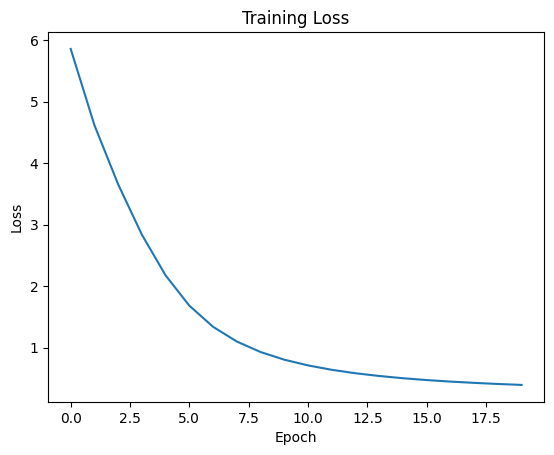


Generated text (temp=1.0):
alice was beginning to begin for a baby said the cat as soon as there was mouth enough under it thats an arm would happen miss the time she thought its very interesting is

Generated text (temp=0.7):
alice was beginning to begin for a baby said the cat as well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisychain

Generated text (temp=1.5):
alice was beginning to feel not it like said alice one of the back and usually find a conversation alice had not the smallest notice of her or children im trying i fell down


In [ ]:
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import gensim.downloader as api


nltk.download('punkt_tab')
nltk.download('gutenberg')


print("Loading corpus...")
text = gutenberg.raw('carroll-alice.txt')
text = text.lower()
text = re.sub(r'[^a-z\s]', '', text)
tokens = word_tokenize(text)


vocab_size = 10000
freqs = Counter(tokens)
most_common = freqs.most_common(vocab_size - 2)
word2idx = {word: i + 2 for i, (word, _) in enumerate(most_common)}
word2idx["<unk>"] = 0
word2idx["<pad>"] = 1
idx2word = {i: w for w, i in word2idx.items()}

encoded = [word2idx.get(w, 0) for w in tokens]


class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx:idx + self.seq_len]),
            torch.tensor(self.data[idx + 1:idx + self.seq_len + 1])
        )

seq_len = 30
batch_size = 64
dataset = TextDataset(encoded, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


print("Loading GloVe vectors...")
glove = api.load("glove-wiki-gigaword-100")
embedding_dim = 100
embedding_matrix = torch.randn(vocab_size, embedding_dim)
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = torch.tensor(glove[word])


class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

hidden_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNLanguageModel(vocab_size, embedding_dim, hidden_dim).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
losses = []

print("Training...")
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}")


plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

def generate_text(model, seed, length=30, temperature=1.0):
    model.eval()
    tokens = word_tokenize(seed.lower())
    indices = [word2idx.get(w, 0) for w in tokens]
    input_seq = torch.tensor(indices).unsqueeze(0).to(device)
    hidden = None
    result = tokens.copy()

    for _ in range(length):
        out, hidden = model(input_seq[:, -seq_len:], hidden)
        last_logits = out[0, -1] / temperature
        probs = F.softmax(last_logits, dim=0)
        next_idx = torch.multinomial(probs, 1).item()
        next_word = idx2word.get(next_idx, "<unk>")
        result.append(next_word)
        input_seq = torch.cat([input_seq, torch.tensor([[next_idx]]).to(device)], dim=1)

    return " ".join(result)


print("\nGenerated text (temp=1.0):")
print(generate_text(model, "alice was beginning to", temperature=1.0))

print("\nGenerated text (temp=0.7):")
print(generate_text(model, "alice was beginning to", temperature=0.7))

print("\nGenerated text (temp=1.5):")
print(generate_text(model, "alice was beginning to", temperature=1.5))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!



Training RNN model...
RNN Epoch 1: Loss = 5.9102
RNN Epoch 2: Loss = 4.6584
RNN Epoch 3: Loss = 3.6599
RNN Epoch 4: Loss = 2.8264
RNN Epoch 5: Loss = 2.1633
RNN Epoch 6: Loss = 1.6778
RNN Epoch 7: Loss = 1.3388
RNN Epoch 8: Loss = 1.1046
RNN Epoch 9: Loss = 0.9373
RNN Epoch 10: Loss = 0.8147
RNN Epoch 11: Loss = 0.7218
RNN Epoch 12: Loss = 0.6496
RNN Epoch 13: Loss = 0.5926
RNN Epoch 14: Loss = 0.5466
RNN Epoch 15: Loss = 0.5098
RNN Epoch 16: Loss = 0.4785
RNN Epoch 17: Loss = 0.4531
RNN Epoch 18: Loss = 0.4314
RNN Epoch 19: Loss = 0.4127
RNN Epoch 20: Loss = 0.3971
RNN training time: 80.33 seconds

Sample generated text (RNN, temp=0.7):
alice was beginning to think it was at the march hare he denies it said the king leave out that part well at any rate the dormouse said the hatter went on again twentyfour


Sample generated text (RNN, temp=1.0):
alice was beginning to think it was no time without him she gave this so she tried to fancy what the flame of a candle is you said the mouse

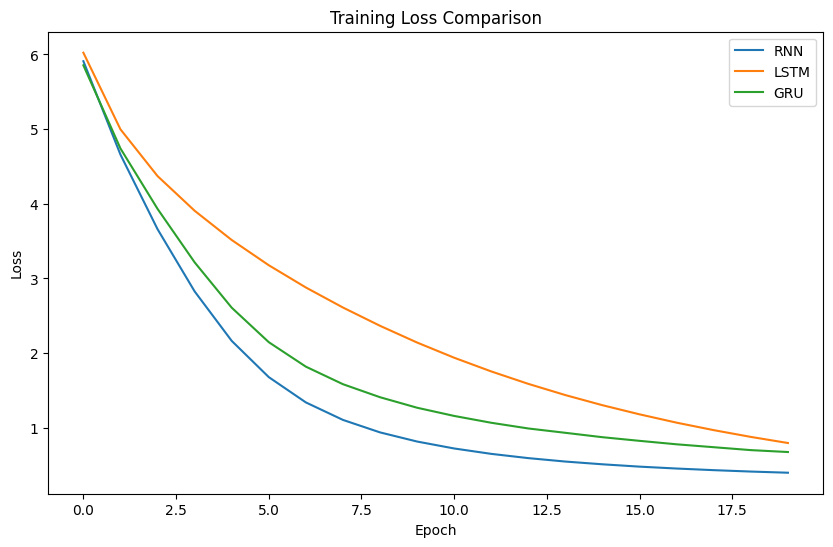

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
import nltk
import gensim.downloader as api
import wandb
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('gutenberg')

wandb.init(project="rnn-model-comparison", config={
    "epochs": 20,
    "batch_size": 64,
    "seq_len": 30,
    "lr": 0.001,
    "embedding_dim": 100,
    "hidden_dim": 128,
    "vocab_size": 10000,
    "dropout": 0.2
})

config = wandb.config

text = gutenberg.raw('carroll-alice.txt').lower()
text = re.sub(r'[^a-z\s]', '', text)
tokens = word_tokenize(text)

freqs = Counter(tokens)
most_common = freqs.most_common(config.vocab_size - 2)
word2idx = {word: i + 2 for i, (word, _) in enumerate(most_common)}
word2idx["<unk>"] = 0
word2idx["<pad>"] = 1
idx2word = {i: w for w, i in word2idx.items()}

encoded = [word2idx.get(w, 0) for w in tokens]

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx:idx + self.seq_len]),
                torch.tensor(self.data[idx + 1:idx + self.seq_len + 1]))

dataset = TextDataset(encoded, config.seq_len)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

glove = api.load("glove-wiki-gigaword-100")
embedding_matrix = torch.randn(config.vocab_size, config.embedding_dim)
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = torch.tensor(glove[word])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, rnn_type='RNN', dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        else:
            raise ValueError("Invalid rnn_type, choose from 'RNN', 'LSTM', 'GRU'")
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

def generate_text(model, seed, length=30, temperature=1.0):
    model.eval()
    tokens = word_tokenize(seed.lower())
    indices = [word2idx.get(w, 0) for w in tokens]
    input_seq = torch.tensor(indices).unsqueeze(0).to(device)
    hidden = None
    result = tokens.copy()
    for _ in range(length):
        out, hidden = model(input_seq[:, -config.seq_len:], hidden)
        last_logits = out[0, -1] / temperature
        probs = F.softmax(last_logits, dim=0)
        next_idx = torch.multinomial(probs, 1).item()
        next_word = idx2word.get(next_idx, "<unk>")
        result.append(next_word)
        input_seq = torch.cat([input_seq, torch.tensor([[next_idx]]).to(device)], dim=1)
    return " ".join(result)

def train_model(rnn_type):
    model = RNNLanguageModel(config.vocab_size, config.embedding_dim, config.hidden_dim, rnn_type=rnn_type, dropout=config.dropout)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    start_time = time.time()
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, config.vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"{rnn_type} Epoch {epoch+1}: Loss = {avg_loss:.4f}")
        wandb.log({f"{rnn_type}_loss": avg_loss, "epoch": epoch + 1})
    elapsed = time.time() - start_time
    print(f"{rnn_type} training time: {elapsed:.2f} seconds")
    wandb.log({f"{rnn_type}_training_time": elapsed})
    temps = [0.7, 1.0, 1.5]
    samples = {}
    for temp in temps:
        sample_text = generate_text(model, "alice was beginning to", temperature=temp)
        wandb.log({f"{rnn_type}_sample_text_temp_{temp}": sample_text})
        samples[temp] = sample_text
        print(f"\nSample generated text ({rnn_type}, temp={temp}):\n{sample_text}\n")
    return losses, elapsed, samples

results = {}
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\nTraining {rnn_type} model...")
    losses, training_time, sample_texts = train_model(rnn_type)
    results[rnn_type] = {
        'losses': losses,
        'training_time': training_time,
        'sample_texts': sample_texts
    }

plt.figure(figsize=(10,6))
for rnn_type in results:
    plt.plot(results[rnn_type]['losses'], label=rnn_type)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

wandb.finish()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!



Training RNN model...

RNN model parameters: 2,547,800


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


RNN Epoch 1: Loss = 5.4249
RNN Epoch 2: Loss = 3.3934
RNN Epoch 3: Loss = 1.9080
RNN Epoch 4: Loss = 1.1454
RNN Epoch 5: Loss = 0.7889
RNN Epoch 6: Loss = 0.6063
RNN Epoch 7: Loss = 0.5011
RNN Epoch 8: Loss = 0.4368
RNN Epoch 9: Loss = 0.3952
RNN Epoch 10: Loss = 0.3656
RNN Epoch 11: Loss = 0.3438
RNN Epoch 12: Loss = 0.3272
RNN Epoch 13: Loss = 0.3143
RNN Epoch 14: Loss = 0.3032
RNN Epoch 15: Loss = 0.2946
RNN Epoch 16: Loss = 0.2870
RNN Epoch 17: Loss = 0.2798
RNN Epoch 18: Loss = 0.2742
RNN Epoch 19: Loss = 0.2695
RNN Epoch 20: Loss = 0.2645
RNN training time: 97.04 seconds

Sample generated text (RNN, temp=0.7):
alice was beginning to feel which way that it which seemed to rise like a stalk out of a sea of green leaves that lay far below her what can all that green stuff


Sample generated text (RNN, temp=1.0):
alice was beginning to feel which way it doesnt believe theres an atom of meaning in it the jury all wrote down on their slates she doesnt believe theres an atom of meaning 

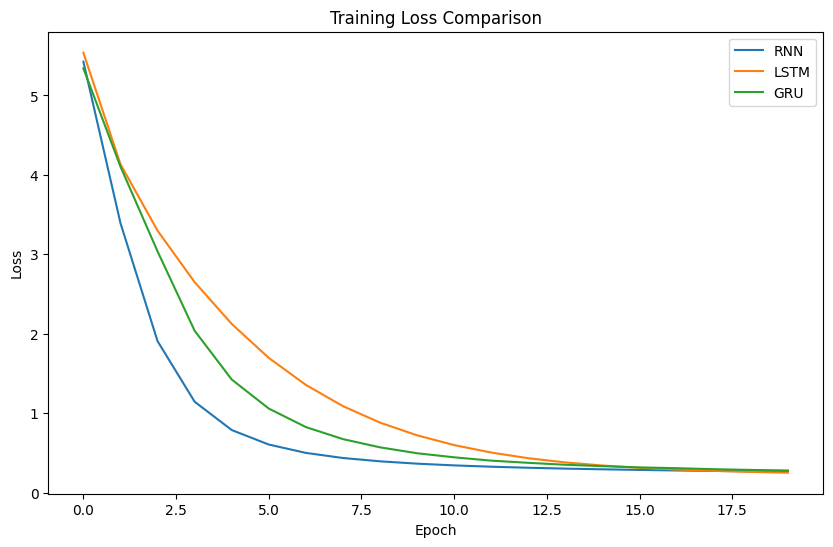

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
import nltk
import gensim.downloader as api
import wandb
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('gutenberg')

wandb.init(project="rnn-model-comparison", config={
    "epochs": 20,
    "batch_size": 64,
    "seq_len": 30,
    "lr_rnn": 0.002,
    "lr_lstm": 0.002,
    "lr_gru": 0.002,
    "embedding_dim": 100,
    "hidden_dim_rnn": 150,
    "hidden_dim_lstm": 150,
    "hidden_dim_gru": 150,
    "vocab_size": 10000,
    "dropout_rnn": 0.2,
    "dropout_lstm": 0.2,
    "dropout_gru": 0.2
})


config = wandb.config

text = gutenberg.raw('carroll-alice.txt').lower()
text = re.sub(r'[^a-z\s]', '', text)
tokens = word_tokenize(text)

freqs = Counter(tokens)
most_common = freqs.most_common(config.vocab_size - 2)
word2idx = {word: i + 2 for i, (word, _) in enumerate(most_common)}
word2idx["<unk>"] = 0
word2idx["<pad>"] = 1
idx2word = {i: w for w, i in word2idx.items()}

encoded = [word2idx.get(w, 0) for w in tokens]

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx:idx + self.seq_len]),
                torch.tensor(self.data[idx + 1:idx + self.seq_len + 1]))

dataset = TextDataset(encoded, config.seq_len)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

glove = api.load("glove-wiki-gigaword-100")
embedding_matrix = torch.randn(config.vocab_size, config.embedding_dim)
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = torch.tensor(glove[word])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, rnn_type='RNN', dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        else:
            raise ValueError("Invalid rnn_type, choose from 'RNN', 'LSTM', 'GRU'")
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def generate_text(model, seed, length=30, temperature=1.0):
    model.eval()
    tokens = word_tokenize(seed.lower())
    indices = [word2idx.get(w, 0) for w in tokens]
    input_seq = torch.tensor(indices).unsqueeze(0).to(device)
    hidden = None
    result = tokens.copy()
    for _ in range(length):
        out, hidden = model(input_seq[:, -config.seq_len:], hidden)
        last_logits = out[0, -1] / temperature
        probs = F.softmax(last_logits, dim=0)
        next_idx = torch.multinomial(probs, 1).item()
        next_word = idx2word.get(next_idx, "<unk>")
        result.append(next_word)
        input_seq = torch.cat([input_seq, torch.tensor([[next_idx]]).to(device)], dim=1)
    return " ".join(result)

def train_model(rnn_type):
    if rnn_type == 'RNN':
        hidden_dim = config.hidden_dim_rnn
        lr = config.lr_rnn
        dropout = config.dropout_rnn
    elif rnn_type == 'LSTM':
        hidden_dim = config.hidden_dim_lstm
        lr = config.lr_lstm
        dropout = config.dropout_lstm
    elif rnn_type == 'GRU':
        hidden_dim = config.hidden_dim_gru
        lr = config.lr_gru
        dropout = config.dropout_gru
    else:
        raise ValueError("Invalid rnn_type")

    model = RNNLanguageModel(config.vocab_size, config.embedding_dim, hidden_dim, rnn_type=rnn_type, dropout=dropout)
    model.to(device)
    print(f"\n{rnn_type} model parameters: {count_parameters(model):,}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    start_time = time.time()
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, config.vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"{rnn_type} Epoch {epoch+1}: Loss = {avg_loss:.4f}")
        wandb.log({f"{rnn_type}_loss": avg_loss, "epoch": epoch + 1})
    elapsed = time.time() - start_time
    print(f"{rnn_type} training time: {elapsed:.2f} seconds")
    wandb.log({f"{rnn_type}_training_time": elapsed})
    temps = [0.7, 1.0, 1.5]
    samples = {}
    for temp in temps:
        sample_text = generate_text(model, "alice was beginning to", temperature=temp)
        wandb.log({f"{rnn_type}_sample_text_temp_{temp}": sample_text})
        samples[temp] = sample_text
        print(f"\nSample generated text ({rnn_type}, temp={temp}):\n{sample_text}\n")
    return losses, elapsed, samples

results = {}
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\nTraining {rnn_type} model...")
    losses, training_time, sample_texts = train_model(rnn_type)
    results[rnn_type] = {
        'losses': losses,
        'training_time': training_time,
        'sample_texts': sample_texts
    }

plt.figure(figsize=(10,6))
for rnn_type in results:
    plt.plot(results[rnn_type]['losses'], label=rnn_type)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

wandb.finish()


RNN całkiem niezłe, zwłaszcza początek zdania, potem występują powtórzenia, zapętlenia - problemy z długoterminową pamięcią. GRU/LSTM powinny być pod tym względem lepsze. Czas treningu podobny.

jhjhjgh